In [1]:
%cd ~/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters


# Función de autocorrelación

In [2]:
import torch
from bwb import logging

__all__ = ["function_1d", "integrated_time", "AutocorrError"]

log = logging.get_logger(__name__)


def next_pow_two(n):
    """Returns the next power of two greater than or equal to `n`"""
    i = 1
    while i < n:
        i = i << 1
    return i


def function_1d(x):
    """Estimate the normalized autocorrelation function of a 1-D series

    Args:
        x: The series as a 1-D PyTorch tensor.

    Returns:
        tensor: The autocorrelation function of the time series.

    """
    x = torch.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Transfer input tensor to the appropriate device (e.g., GPU)
    device = x.device

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fft(x - torch.mean(x), n=2 * n)
    acf = torch.fft.ifft(f * torch.conj(f))[: len(x)].real
    acf /= acf[0].item()

    # Transfer the result back to the original device (if necessary)
    acf = acf.to(device)

    return acf


def auto_window(taus, c, device=None):
    if device is None:
        device = taus.device

    m = torch.arange(len(taus), device=device) < c * taus
    if torch.any(m):
        return torch.argmin(m.long()).item()
    return len(taus) - 1


def integrated_time(x, c=5, tol=50, quiet=True, has_walkers=True, device=None):
    """Estimate the integrated autocorrelation time of a time series.

    This estimate uses the iterative procedure described on page 16 of
    `Sokal's notes <https://www.semanticscholar.org/paper/Monte-Carlo-Methods-in-Statistical-Mechanics%3A-and-Sokal/0bfe9e3db30605fe2d4d26e1a288a5e2997e7225>`_ to
    determine a reasonable window size.

    Args:
        x (torch.Tensor): The time series. If 2-dimensional, the tensor
            dimensions are interpreted as ``(n_step, n_walker)`` unless
            ``has_walkers==False``, in which case they are interpreted as
            ``(n_step, n_param)``. If 3-dimensional, the dimensions are
            interpreted as ``(n_step, n_walker, n_param)``.
        c (Optional[float]): The step size for the window search. (default:
            ``5``)
        tol (Optional[float]): The minimum number of autocorrelation times
            needed to trust the estimate. (default: ``50``)
        quiet (Optional[bool]): This argument controls the behavior when the
            chain is too short. If ``True``, give a warning instead of raising
            an :class:`AutocorrError`. (default: ``False``)
        has_walkers (Optional[bool]): Whether the last axis should be
            interpreted as walkers or parameters if ``x`` has 2 dimensions.
            (default: ``True``)
        device (Optional[torch.device]): The target device for computation.
            If not specified, the device of the input tensor `x` will be used.

    Returns:
        float or tensor: An estimate of the integrated autocorrelation time of
            the time series ``x``.

    Raises
        AutocorrError: If the autocorrelation time can't be reliably estimated
            from the chain and ``quiet`` is ``False``. This normally means
            that the chain is too short.

    """
    # Check if a device is specified, otherwise use the device of the input tensor
    if device is None:
        device = x.device

    x = torch.atleast_1d(x.to(device))
    if len(x.shape) == 1:
        x = x[:, None, None]
    if len(x.shape) == 2:
        if not has_walkers:
            x = x[:, None, :]
        else:
            x = x[:, :, None]
    if len(x.shape) != 3:
        raise ValueError("invalid dimensions")

    n_t, n_w, n_d = x.shape
    tau_est = torch.empty(n_d, device=device)
    windows = torch.empty(n_d, dtype=torch.int, device=device)

    # Loop over parameters
    for d in range(n_d):
        f = torch.zeros(n_t, device=device)
        for k in range(n_w):
            f += function_1d(x[:, k, d])
        f /= n_w
        taus = 2.0 * torch.cumsum(f, dim=0) - 1.0
        taus = taus.to(device)
        windows[d] = auto_window(taus, c)
        tau_est[d] = taus[windows[d]]

    # Check convergence
    flag = tol * tau_est > n_t

    # Warn or raise in the case of non-convergence
    if torch.any(flag):
        msg = (
            "The chain is shorter than {0} times the integrated "
            "autocorrelation time for {1} parameter(s). Use this estimate "
            "with caution and run a longer chain!\n"
        ).format(tol, torch.sum(flag))
        msg += "N/{0} = {1:.0f};\ntau: {2}".format(tol, n_t / tol, tau_est)
        if not quiet:
            raise AutocorrError(tau_est.cpu(), msg)
        log.warning(msg)

    return tau_est


class AutocorrError(Exception):
    """Raised if the chain is too short to estimate an autocorrelation time.

    The current estimate of the autocorrelation time can be accessed via the
    ``tau`` attribute of this exception.

    """

    def __init__(self, tau, *args, **kwargs):
        self.tau = tau
        super(AutocorrError, self).__init__(*args, **kwargs)

# Posterior Explícita

In [3]:
import numpy as np

from bwb.distributions.data_loaders import DistributionDrawDataLoader
from bwb.distributions import ExplicitPosteriorSampler

expl_posterior = ExplicitPosteriorSampler()
expl_posterior

ExplicitPosteriorSampler()

In [4]:
from pathlib import Path

data_path = Path("./data/face.npy")

models_array = np.load(data_path)
n_faces, _ = models_array.shape
print(f"{n_faces = }")

faces = DistributionDrawDataLoader(models_array, (28, 28))

n_faces = 161666


In [5]:
face0 = faces[0]
face0

In [6]:
import torch
torch.manual_seed(42)

data = faces[0].sample((100,))
data

tensor([478,  91, 298, 116, 188, 332, 593, 300, 354, 255, 239, 659, 627,  96,
        294, 126, 603, 247, 353, 227,  91, 637, 685, 157, 217, 323, 118, 337,
        662, 290, 118, 244, 529, 244, 204, 633, 246, 227, 124, 602, 474, 275,
        688, 326, 659, 571, 145, 622, 154, 474, 204, 630, 636, 592, 242, 200,
        584, 298, 244, 611, 304, 187,  94, 234, 233, 298, 332, 262, 500, 282,
        529, 662, 244, 117, 690, 247, 352, 449, 478, 268, 611, 339, 568, 528,
        655, 268, 213, 282, 598, 254, 608, 657, 242, 565, 352,  94, 390, 623,
        117, 354], device='cuda:0')

In [7]:
face0.enumerate_support_()

tensor([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        ...,
        [27, 25],
        [27, 26],
        [27, 27]], device='cuda:0')

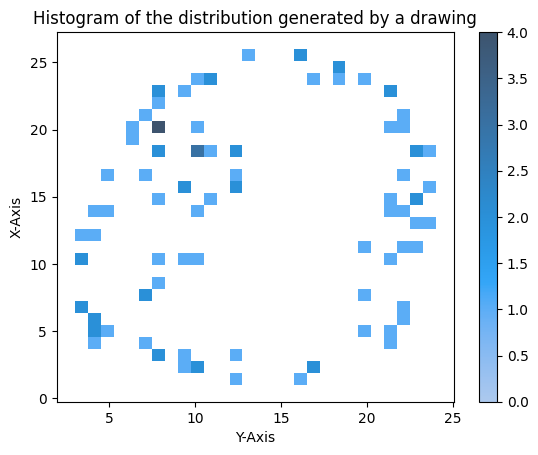

In [8]:
import bwb.utils as utils
import matplotlib.pyplot as plt

data_coords = face0.enumerate_support_()[data].cpu().numpy()

utils.plot_histogram_from_points(data_coords, histplot_kwargs=dict(bins=28))
plt.show()

In [9]:
data_5 = data[:5]
data_50 = data[:50]
data_100 = data[:100]
data_coords_5 = data_coords[:5]
data_coords_50 = data_coords[:50]
data_coords_100 = data_coords[:100]

In [10]:
data_5.dtype

torch.int64

In [11]:
max_images = 3 * 13
expl_posterior = ExplicitPosteriorSampler()
expl_posterior.fit(data=data_5, models=faces)
expl_posterior.rvs(1_000, seed=42)

print(f"Total time: {expl_posterior.total_time:.2f} seconds")

expl_posterior

Total time: 0.33 seconds


ExplicitPosteriorSampler(n_data=5, n_models=161666, n_support=4215, samples=1000)

In [12]:
most_common = [faces[i] for i, _ in expl_posterior.samples_counter.most_common(max_images)]
utils.plot_list_of_draws(
    most_common, 
    labels=utils.freq_labels_posterior(expl_posterior), 
    max_images=max_images
)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/discrete_distribution.py:252: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  self._grayscale = _grayscale(to_return, weights, support)


In [13]:
max_images = 3 * 13
expl_posterior = ExplicitPosteriorSampler()
expl_posterior.fit(data=data[:10], models=faces)
expl_posterior.rvs(1_000, seed=42)
print(f"Total time: {expl_posterior.total_time:.2f} seconds")
most_common = [faces[i] for i, _ in expl_posterior.samples_counter.most_common(max_images)]
utils.plot_list_of_draws(
    most_common, 
    labels=utils.freq_labels_posterior(expl_posterior), 
    max_images=max_images
)

Total time: 0.08 seconds


In [14]:
max_images = 3 * 13
expl_posterior = ExplicitPosteriorSampler()
expl_posterior.fit(data=data[:20], models=faces)
expl_posterior.rvs(1_000, seed=42)
print(f"Total time: {expl_posterior.total_time:.2f} seconds")
most_common = [faces[i] for i, _ in expl_posterior.samples_counter.most_common(max_images)]
utils.plot_list_of_draws(
    most_common, 
    labels=utils.freq_labels_posterior(expl_posterior), 
    max_images=max_images
)

Total time: 0.02 seconds


In [15]:
from bwb.distributions.posterior_distributions import UniformDiscreteSampler
max_images = 3 * 13
uniform_sampler = UniformDiscreteSampler()
uniform_sampler.fit(models=faces)
uniform_sampler.rvs(1_000, seed=42)
print(f"Total time: {uniform_sampler.total_time:.2f} seconds")
most_common = [faces[i] for i, _ in uniform_sampler.samples_counter.most_common(max_images)]
utils.plot_list_of_draws(
    most_common, 
    labels=utils.freq_labels_posterior(uniform_sampler), 
    max_images=max_images
)
uniform_sampler

Total time: 0.57 seconds


UniformDiscreteSampler(n_models=161666, samples=1000)

In [16]:
old_dict = dict(a=1, b=2)
old_dict.setdefault("c", 2)
new_dict = dict(a=2, c=4)
old_dict.update(new_dict)
old_dict

{'a': 2, 'b': 2, 'c': 4}

In [17]:
from quickdraw_dataset import QuickDraw
import torchvision.transforms as T
from pathlib import Path
from bwb.utils import _ArrayLike
from torch.utils.data import DataLoader
from bwb.config import config
import multiprocessing as mp
import bwb.distributions as dist

ds = QuickDraw(
    Path("./data"),
    category="face",
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x.squeeze()),
    ])
)

class DatasetWrapper:
    def __init__(self, dataset, dataloader_args=None, device=None, dtype=None, eps=None):
        self.dataset = dataset

        self.dataloader_args = dataloader_args or dict()
        default_args = dict(batch_size=1024, shuffle=False, num_workers=mp.cpu_count())
        for key, value in default_args.items():
            self.dataloader_args.setdefault(key, value)

        self.device = torch.device(device or config.device)
        # If we are working in cuda
        if self.device.type == "cuda":
            self.dataloader_args.setdefault("pin_memory", True)

        self.dtype = dtype or config.dtype

        self.eps = eps or config.eps

    def __len__(self):
        return len(self.dataset)

    def compute_likelihood(self, data: _ArrayLike, **kwargs) -> torch.Tensor:
        dataloader = DataLoader(self.dataset, **self.dataloader_args)
        data = torch.as_tensor(data, device=self.device).reshape(1, -1)

        likelihoods = []

        for features, _ in dataloader:
            # Transfer the features to the appropriate device
            features = torch.as_tensor(features, device=self.device, dtype=self.dtype)
            # Flatten the features
            features = features.reshape(features.size(0), -1)
            # Normalize the features
            features = features / features.sum(dim=1, keepdim=True)
            # Compute the log of the features
            features = torch.log(features + self.eps)
            # Compute the likelihood
            evaluations = torch.take_along_dim(features, data, 1)
            likelihood = torch.exp(evaluations.sum(dim=1))

            likelihoods.append(likelihood)

        likelihood_cache = torch.cat(likelihoods, dim=0)

        probabilities = likelihood_cache / (likelihood_cache.sum() + self.eps)

        return probabilities
    
    def get(self, i: int, **kwargs) -> dist.DistributionDraw:
        return dist.DistributionDraw.from_grayscale_weights(self.dataset[i][0])
    

ds_wrapped = DatasetWrapper(ds)


ds_wrapped.get(1)
ds_wrapped.compute_likelihood(data)

tensor([4.4149e-223,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00], device='cuda:0', dtype=torch.float64)

In [18]:
max_images = 3 * 13
expl_posterior = ExplicitPosteriorSampler()
expl_posterior.fit(data=data[:20], models=ds_wrapped)
print(f"Total time: {expl_posterior.total_time:.2f} seconds")
expl_posterior.rvs(1_000, seed=42)
print(f"Total time: {expl_posterior.total_time:.2f} seconds")
most_common = [faces[i] for i, _ in expl_posterior.samples_counter.most_common(max_images)]
utils.plot_list_of_draws(
    most_common, 
    labels=utils.freq_labels_posterior(expl_posterior), 
    max_images=max_images
)

Total time: 3.55 seconds
Total time: 3.55 seconds


In [19]:
expl_posterior.models_.get(0)

In [20]:
%%time
expl_posterior.fit(data=data, models=faces)

CPU times: user 23.2 ms, sys: 716 µs, total: 23.9 ms
Wall time: 23.4 ms


ExplicitPosteriorSampler(n_data=100, n_models=161666, n_support=1, samples=1000)

In [21]:
%%time
expl_posterior.rvs(size=1000, seed=42)
print()


CPU times: user 5.6 ms, sys: 0 ns, total: 5.6 ms
Wall time: 4.43 ms


In [22]:
expl_posterior.total_time

3.5824327320005978

In [23]:
expl_posterior2 = ExplicitPosteriorSampler()
expl_posterior2.total_time, expl_posterior.total_time

(0.0, 3.5824327320005978)

In [24]:
try:
    expl_posterior2.draw()
except Exception as e:
    print(e)

This ExplicitPosteriorSampler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [25]:
len(expl_posterior.samples_counter)

5

In [26]:
print(expl_posterior.samples_counter.total())
expl_posterior.draw()
print(expl_posterior.samples_counter.total())

2000
2001


In [27]:
expl_posterior.draw()

In [28]:
del expl_posterior, expl_posterior2, faces, models_array

# Importar redes

In [36]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NOISE = "unif"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

CURR_PATH = Path(".")
NETS_PATH = CURR_PATH / "wgan_gp" / "networks" 
# FACE_PATH = NETS_PATH / f"_resnet_face_zDim{LATENT_DIM}_gauss_bs_128_recognized_augmented_WAE_WGAN_loss_l1_32p32"
FACE_PATH = NETS_PATH / f"_resnet_face_zDim{LATENT_DIM}_unif_bs_128_cleaned_augmented_WAE_WGAN_loss_l1_32p32"

from wgan_gp.wgan_gp_vae.utils import load_checkpoint

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(), E.eval()
print()

In [37]:
G._latent_distr

wgan_gp.wgan_gp_vae.model_resnet.unif

In [38]:
data

tensor([478,  91, 298, 116, 188, 332, 593, 300, 354, 255, 239, 659, 627,  96,
        294, 126, 603, 247, 353, 227,  91, 637, 685, 157, 217, 323, 118, 337,
        662, 290, 118, 244, 529, 244, 204, 633, 246, 227, 124, 602, 474, 275,
        688, 326, 659, 571, 145, 622, 154, 474, 204, 630, 636, 592, 242, 200,
        584, 298, 244, 611, 304, 187,  94, 234, 233, 298, 332, 262, 500, 282,
        529, 662, 244, 117, 690, 247, 352, 449, 478, 268, 611, 339, 568, 528,
        655, 268, 213, 282, 598, 254, 608, 657, 242, 565, 352,  94, 390, 623,
        117, 354], device='cuda:0')

In [39]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [40]:
z_ = torch.zeros((1,), device="cuda")
# z = G.sample_noise(100, type_as=z_)
G_script = torch.jit.script(G)
# G_script(z)
G, G_ = torch.jit.freeze(G_script), G


In [41]:
G

RecursiveScriptModule(original_name=Generator)

In [42]:
face0.grayscale_weights.shape

torch.Size([28, 28])

In [43]:
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T

z = G_.sample_noise(1, type_as=z_)
m = G(z)
transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImageTensor(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])
transform_out = T.Compose([
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])
transform_out(m)

tensor([[2.8875e-06, 1.3577e-08, 1.9008e-08,  ..., 1.4291e-10, 1.1433e-09,
         1.6864e-08],
        [2.3801e-06, 1.1719e-08, 8.1462e-09,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.1151e-08, 7.1458e-10, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.1458e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.4291e-10]], device='cuda:0')

seed = 4102165607616432379
data = tensor([355, 577, 791, 841, 774, 837, 514, 822, 762, 342, 309, 211, 843, 375,
        387, 709, 167, 247, 794, 510, 747, 427, 853, 228, 509, 337, 465, 850,
        445, 427, 445, 763, 308, 819, 878, 681, 260, 790, 292, 171, 360, 433,
        844, 427, 482, 509, 741, 140, 821, 741, 877, 701, 299, 822, 342, 392,
        196, 733, 481, 855, 700, 339, 780, 402, 258, 387, 433, 572, 877, 213,
        668, 914, 676, 277, 364, 823, 541, 338, 199, 547, 396, 342, 405, 336,
        790, 327, 917, 137, 170, 332, 796, 341, 309, 712, 338, 777, 884, 499,
        846, 381], device='cuda:0')


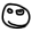

In [44]:
import bwb.distributions as bwb_dist
seed = 4102165607616432379
print(f"{seed = }")
torch.manual_seed(seed)

with torch.no_grad():
    m = transform_in(face0.grayscale_weights).unsqueeze(0).to(device)
    z = E(m)
    m = G(z)

m = transform_out(m)

face = bwb_dist.DistributionDraw.from_grayscale_weights(m)
data = face.sample((100,))
print(f"{data = }")
face

# MCMC

![](https://quicklatex.com/cache3/e9/ql_ee61247290f642a5afc1fc6205cc98e9_l3.png)

In [45]:
z = G_.sample_noise(1, type_as=z_).squeeze()
z_abs = torch.abs(z)
constraint = torch.maximum(z_abs - 1, torch.zeros_like(z_abs))
penalizations = 1e6 * constraint ** 2
constraint, penalizations.sum()

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor(0., device='cuda:0'))

In [46]:
@torch.jit.script
def _log_prior_unif(z: torch.Tensor, radius=torch.tensor(1), penalizaton=torch.tensor(1e6)):
    """
    Compute the log-prior of the latent variable z. The prior is uniform [-1, 1].
    """
    z = z.squeeze()
    z_abs = torch.abs(z)
    constraint = torch.maximum(z_abs - radius, torch.zeros_like(z_abs))
    penalizations = penalizaton * constraint ** 2
    return -torch.sum(penalizations)

@torch.jit.script
def _log_prior_norm(z: torch.Tensor, radius=torch.tensor(3), penalizaton=torch.tensor(1e6)):
    """
    Compute the log-prior of the latent variable z.
    """
    z = z.squeeze()
    # min_value = torch.finfo(z.dtype).min
    norm_z_2 = torch.sum(z ** 2)  # \|z\|^2
    n = z.shape[0]
    constraint = torch.maximum(norm_z_2 / n - radius ** 2, torch.zeros_like(norm_z_2))
    penalizations = penalizaton * constraint ** 2
    return -norm_z_2 / 2 - penalizations  # -\frac{1}{2} \|z\|^2

# @torch.jit.script
def _log_prior(z: torch.Tensor, G, radius=torch.tensor(1), penalizaton=torch.tensor(1e6)):
    """
    Compute the log-prior of the latent variable z.
    """
    if G._latent_distr(1).name == "unif":
        return _log_prior_unif(z, radius, penalizaton)
    elif G._latent_distr(1).name == "norm":
        return _log_prior_norm(z, radius, penalizaton)
    raise ValueError(f"unknown latent distribution {G._latent_distr(1).name}")

# @torch.jit.script
def _log_likelihood_latent(z: torch.Tensor, data:torch.Tensor, generator: torch.jit.ScriptModule, transform_out):
    """
    Compute the log-likelihood of the data given the latent variable z.
    This is done by first generating the image x from z, then transforming it to a DistributionDraw object.
    
    The original likelihood is:
    .. math::
        \Pi_n(dm)
        \propto \Pi(dm) \mathcal{L}_n(m)
        = \int_{\mathcal{Z}} P_Z(dz) \Pi(dm | z) \mathcal{L}_n(m)
        \propto \int_{\mathcal{Z}} dz \Pi(dm | z) \mathcal{L}_n(m) e^{-\frac{1}{2} \|z\|^2}
        = \int_{\mathcal{Z}} dz \Pi(dm | z) \prod_{i=1}^n m(x_i) e^{-\frac{1}{2} \|z\|^2}

    So, the log-likelihood with respecto to z is:
    .. math::
        \ell_n(z) = \sum_{i=1}^n \log m(x_i) - \frac{1}{2} \|z\|^2
    """
    eps = torch.finfo(z.dtype).eps
    
    z = torch.reshape(z, (1, -1, 1, 1))
    with torch.no_grad():
        m = generator(z)    
    m = transform_out(m)
    m = m.reshape((-1,))
    
    # m_data = m.take(data) + eps  # to avoid log(0)
    # logits = torch.log(m_data)  # log m(x_i)
    
    m_data = m.take(data)
    # m_data_zeros = m_data == 0
    m_data = m_data + eps  # to avoid log(0)
    logits = torch.log(m_data)  # log m(x_i)
    # logits[m_data_zeros] = logits[m_data_zeros] * 3
    
    return torch.sum(logits) # \sum_{i=1}^n \log m(x_i)

# @torch.jit.script
def _log_posterior(z: torch.Tensor, data: torch.Tensor, generator: torch.nn.Module, transform_out, radius=torch.tensor(1), penalization=torch.tensor(1e6)):
    """
    Compute the log-posterior of the latent variable z.
    .. math::
        \log \Pi_n(z) = \log \Pi_Z(z) + \log \Pi_n(dm)
    """
    return _log_prior_unif(z, radius, penalization) + _log_likelihood_latent(z, data, generator, transform_out)

z = G_.sample_noise(1, type_as=z_).squeeze()

_log_likelihood_latent(z, data, G, transform_out), _log_posterior(z, data, G, transform_out)

(tensor(-824.8838, device='cuda:0'), tensor(-824.8838, device='cuda:0'))

In [47]:
# @torch.jit.script
def _log_likelihood_true_latent(z: torch.Tensor, data:torch.Tensor, generator: torch.nn.Module, transform_out):
    """
    Compute the log-likelihood of the data given the latent variable z.
    This is done by first generating the image x from z, then transforming it to a DistributionDraw object.
    
    The original likelihood is:
    .. math::
        \Pi_n(dm)
        \propto \Pi(dm) \mathcal{L}_n(m)
        = \int_{\mathcal{Z}} P_Z(dz) \Pi(dm | z) \mathcal{L}_n(m)
        \propto \int_{\mathcal{Z}} dz \Pi(dm | z) \mathcal{L}_n(m) e^{-\frac{1}{2} \|z\|^2}
        = \int_{\mathcal{Z}} dz \Pi(dm | z) \prod_{i=1}^n m(x_i) e^{-\frac{1}{2} \|z\|^2}

    So, the log-likelihood with respecto to z is:
    .. math::
        \ell_n(z) = \sum_{i=1}^n \log m(x_i) - \frac{1}{2} \|z\|^2
    """
    eps = torch.finfo(z.dtype).eps
    
    z = torch.reshape(z, (1, -1, 1, 1))
    with torch.no_grad():
        m = generator(z)    
    m = transform_out(m)
    m = m.reshape((-1,))
    
    m_data = m.take(data)
    m_data_zeros = m_data == 0
    m_data = m_data + eps  # to avoid log(0)
    logits = torch.log(m_data)  # log m(x_i)
    logits[m_data_zeros] = logits[m_data_zeros] * 10
    
    return torch.sum(logits) # \sum_{i=1}^n \log m(x_i)

_log_likelihood_true_latent(z, data, G, transform_out)

tensor(-824.8838, device='cuda:0')

In [48]:
# for _ in range(10):
#     z = G.sample_noise(1).squeeze()
#     print(_log_likelihood_true_latent(z, data, G, transform_out), _log_prior(z), _log_posterior(z, data, G, transform_out))

## MCMC Clase Base

In [49]:
import torch

from bwb.distributions import PosteriorPiN
from bwb.distributions.posterior_distributions import _timeit_to_total_time
from bwb.utils import _ArrayLike
import bwb.validation as bwb_val
import hamiltorch
from hamiltorch import Sampler, Integrator, Metric
import random


class _LatentMCMCPosteriorPiN(PosteriorPiN[bwb_dist.DistributionDraw]):
    """
    The posterior Pi_n distribution using MCMC sampling of the latent variable z.
    """
    def __init__(
            self,
            log_prob_fn=_log_posterior,
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1,
            sampler=Sampler.HMC, 
            **kwargs
        ) -> None:
        super().__init__(log_prob_fn)
        self.samples_history: list[list[torch.Tensor]] = [[]]
        self.samples_cache: list[torch.Tensor] = []
        self.hamiltorch_kwargs = dict(
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            sampler=sampler,
        )
        self.hamiltorch_kwargs.update(kwargs)
        self.hamiltorch_kwargs.setdefault("debug", 0)
        self.log = None
    
    def fit(self, data: _ArrayLike, generator: torch.nn.Module, transform_out: T.Compose):
        """
        Fits the posterior distribution to the data, using the generator and the transform_out.
        """
        super().fit(data)
        self.generator_ = generator
        self.transform_out_ = transform_out
        return self

    def log_prob(self, z: torch.Tensor):
        """
        The logarithm of the probability to use in the MCMC sampling.
        """
        bwb_val.check_is_fitted(self, ["data_", "generator_", "transform_out_"])
        return self.log_prob_fn(z, self.data_, self.generator_, self.transform_out_)

    def reset_samples(self):
        """
        Resets the samples cache.
        """
        self.samples_cache = []
        return self
    
    def _get_hamiltorch_kwargs(self, **kwargs):
        hamiltorch_kwargs = self.hamiltorch_kwargs.copy()
        specific_kwargs = dict(
            log_prob_func=self.log_prob,
            **kwargs
        )
        hamiltorch_kwargs.update( (k, v) for k, v in specific_kwargs.items() if v is not None )
        hamiltorch_kwargs["num_samples"] = hamiltorch_kwargs["num_samples"] + hamiltorch_kwargs["burn"]

        return hamiltorch_kwargs
    
    
    @_timeit_to_total_time
    def run(
            self, 
            params_init=None,
            num_samples=None, 
            burn=None,
            **kwargs
        ):
        """
        Runs the MCMC sampling.
        """
        bwb_val.check_is_fitted(self, ["generator_", "transform_out_", "data_"])
        
        z_init: torch.Tensor = params_init or G_.sample_noise(1, type_as=z_).squeeze()

        hamiltorch_kwargs = self._get_hamiltorch_kwargs(
            params_init=z_init, 
            num_samples=num_samples, 
            burn=burn, 
            **kwargs
        )
        debug = hamiltorch_kwargs["debug"]

        if debug == 2:
            samples, self.log = hamiltorch.sample(**hamiltorch_kwargs)
        else:
            samples = hamiltorch.sample(**hamiltorch_kwargs)

        self.samples_history[0].extend(samples)
        
        return self
    
    def get_chain(self, flat=False, thin=1, discard=0):
        """
        Returns the chain with shape (n_step, n_walker, n_param), or (n_step * n_walker, n_param) if flat=True.
        """
        to_return = torch.stack(self.samples_history[0][discard::thin]).unsqueeze(1)
        if flat:
            to_return = to_return.reshape((-1, to_return.shape[-1]))
        return to_return
    
    def get_autocorr_time(self, thin=1, discard=0, **kwargs):
        """
        Returns the autocorrelation time of the chain.
        """
        chain = self.get_chain(thin=thin, discard=discard)
        return thin * integrated_time(chain, **kwargs)
    
    def shuffle_samples_cache(self, thin=1, discard=0):
        """
        Creates a new samples cache by shuffling the chain.
        """
        to_extend = self.get_chain(flat=True, thin=thin, discard=discard)
        to_extend = [sample for sample in to_extend]
        to_extend = random.sample(to_extend, len(to_extend))
        self.samples_cache.extend(to_extend)
        return self

    def _draw(self):
        if not self.samples_cache:
            self.run()
            self.shuffle_samples_cache()
        
        z_sampled = self.samples_cache.pop(0)
        grayscale_weights = self.transform_out_(self.generator_(z_sampled.reshape(1, -1, 1, 1)).squeeze())
        return bwb_dist.DistributionDraw.from_grayscale_weights(grayscale_weights)
    
    def _rvs(self, size=1):
        if len(self.samples_cache) < size:
            self.run(num_samples=size)
            self.shuffle_samples_cache()

        samples, self.samples_cache = self.samples_cache[:size], self.samples_cache[size:]
        samples_ = []
        for z in samples:
            grayscale_weights = self.transform_out_(self.generator_(z.reshape(1, -1, 1, 1)).squeeze())
            samples_.append(bwb_dist.DistributionDraw.from_grayscale_weights(grayscale_weights))
        return samples_

    @_timeit_to_total_time
    def draw(self) -> bwb_dist.DistributionDraw:
        return self._draw()

    @_timeit_to_total_time
    def rvs(self, size=1) -> list[bwb_dist.DistributionDraw]:
        return self._rvs(size)
    
    def _additional_repr_(self, sep):
        return ""

    def __repr__(self, sep=", "):
        to_return = self.__class__.__name__ + "("

        if hasattr(self, "data_"):
            to_return += f"n_data={len(self.data_)}" + sep

        if self.samples_history[0]:
            to_return += f"n_total_iterations={len(self.samples_history[0])}" + sep

        if self.samples_cache:
            to_return += f"n_cached_samples={len(self.samples_cache)}" + sep

        to_return += self._additional_repr_(sep)

        if to_return[-len(sep):] == sep:
            to_return = to_return[:-len(sep)]
        
        to_return += ")"

        return to_return
    
_LatentMCMCPosteriorPiN()

_LatentMCMCPosteriorPiN()

## MCMC paralelo

In [50]:
class LatentMCMCPosteriorPiN(_LatentMCMCPosteriorPiN):
    def __init__(
            self,
            n_workers=None,
            n_walkers=1,
            log_prob_fn=_log_posterior,
            num_samples=10,
            num_steps_per_sample=10,
            burn=10,
            step_size=0.1,
            sampler=Sampler.HMC,
            parallel=False,
            **kwargs
    ):
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            sampler=sampler,
            **kwargs
        )
        self.n_workers = n_workers
        self.n_walkers = n_walkers
        self.parallel = parallel
        self.samples_history: list[list[torch.Tensor]] = [[] for _ in range(n_walkers)]

    @_timeit_to_total_time
    def run(
            self,
            n_workers=None,
            n_walkers=None,
            seeds=None, 
            num_samples=None,
            burn=None,
            parallel=None,
            **kwargs
    ):
        bwb_val.check_is_fitted(self, ["generator_", "transform_out_", "data_"])

        n_workers = n_workers or self.n_workers
        n_walkers = n_walkers or self.n_walkers
        parallel = parallel or self.parallel

        seeds = seeds or torch.arange(n_walkers)
        assert len(seeds) == n_walkers, "The number of seeds must be equals to the number of walkers."

        prior = lambda : G_.sample_noise(1, type_as=z_).squeeze()

        hamiltorch_kwargs = self._get_hamiltorch_kwargs(num_samples=num_samples, burn=burn, **kwargs)
        debug = hamiltorch_kwargs["debug"]

        chain = hamiltorch.util.setup_chain(hamiltorch.sample, prior, hamiltorch_kwargs)

        params_hmc = hamiltorch.util.multi_chain(chain, self.n_workers, seeds, parallel)

        other_list = []
        for i, params in enumerate(params_hmc):
            if debug == 2:
                params, other = params
                self.samples_history[i].extend(params)
                other_list.append(other)
            self.samples_history[i].extend(params)

        self.log = other_list

        return self
    

    def get_chain(self, flat=False, thin=1, discard=0):
        samples_per_chain = [torch.stack(self.samples_history[i]) for i in range(self.n_walkers)]
        to_return = torch.stack(samples_per_chain, dim=1)
        to_return = to_return[discard::thin]
        if flat:
            to_return = to_return.flatten(0, 1)
        return to_return
    
    def _additional_repr_(self, sep):
        to_return = super()._additional_repr_(sep)
        if self.n_workers is not None:
            to_return += f"n_workers={self.n_workers}" + sep
        if self.n_walkers > 1:
            to_return += f"n_walkers={self.n_walkers}" + sep
        if self.parallel:
            to_return += f"parallel={self.parallel}" + sep
        return to_return
    
    
LatentMCMCPosteriorPiN(parallel=True), LatentMCMCPosteriorPiN(n_workers=2), LatentMCMCPosteriorPiN(n_walkers=2)

(LatentMCMCPosteriorPiN(parallel=True),
 LatentMCMCPosteriorPiN(n_workers=2),
 LatentMCMCPosteriorPiN(n_walkers=2))

## Nu-U-Turn-Sampler (NUTS)

In [57]:
burn = 200
num_samples = 20_000

In [58]:
import bwb.utils as bwb_utils


class NUTSPosteriorPiN(LatentMCMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior, 
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1, 
            desired_accept_rate=0.6, 
            n_workers=None,
            n_walkers=1,
            parallel=False,
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            sampler=Sampler.HMC_NUTS,
            desired_accept_rate=desired_accept_rate,
            n_workers=n_workers,
            n_walkers=n_walkers,
            parallel=parallel,
            **kwargs
        )

In [59]:
post_pi_n = NUTSPosteriorPiN(
    n_walkers=8,
    num_steps_per_sample=1,
    burn=burn,
    desired_accept_rate=0.6,
).fit(data[:100], G, transform_out).run(num_samples=num_samples)

post_pi_n

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.004305041395127773-- |   199/20200 | 87.07       
0d:00:03:41 | 0d:00:00:00 | #################### | 20200/20200 | 91.14        
Acceptance Rate 0.73
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.006290509831160307-- |   180/20200 | 77.09        
0d:00:04:20 | 0d:00:00:00 | #################### | 20200/20200 | 77.59       
Acceptance Rate 0.63
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.006719421129673719-- |   184/20200 | 79.98       
0d:00:03:26 | 0d:00:00:00 | #################### | 20200/20200 | 97.60       
Acceptance Rate 0.63
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples  

NUTSPosteriorPiN(n_data=100, n_total_iterations=20000, n_walkers=8)

In [60]:
mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())

2023-10-15 12:14:16,640: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: tensor([2373.0544, 2149.3010, 2234.5273, 1849.8962, 2131.0129, 2298.2837,
        2350.5383, 2221.4937, 2273.7451, 2208.1833, 2148.5225, 2327.6218,
        1898.9562, 2197.1736, 2114.3901, 2215.7061, 1911.7328, 2578.0950,
        2255.8171, 2326.4658, 2260.3655, 2145.5637, 2367.1921, 2311.5959,
        2285.9390, 2175.7185, 1391.8502, 2367.1487, 1827.5322, 2511.9556,
        2360.9099, 2466.3877, 2024.0979, 1907.4121, 2224.7097, 2326.8420,
        2036.7755, 2395.3938, 2454.5547, 2289.3179, 1680.5742, 2521.7520,
        2082.7231, 1509.2642, 2210.0256, 1819.2970, 1746.4902, 1919.2963,
        1944.6134, 2144.3770, 2079.5435, 2153.0503, 1949.7118, 2409.4343,
        2007.0107, 2299.8403, 2163.9946, 2066.1799, 2019.5331, 2065.7239,
        2161.7986, 1530.3198, 2463.6521, 2087

In [61]:
post_pi_n.shuffle_samples_cache(thin=mean_autocorr_time)

NUTSPosteriorPiN(n_data=100, n_total_iterations=20000, n_cached_samples=80, n_walkers=8)


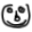
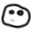
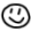
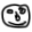
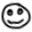
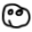
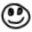
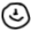
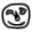
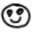
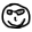
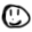
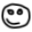
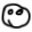
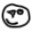
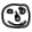
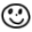
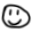
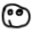
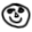
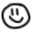
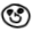
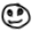
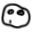
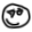
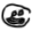
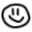
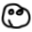
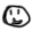
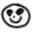
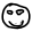
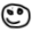
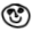
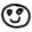
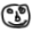
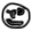
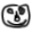
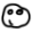
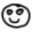
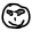
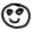
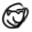
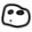
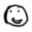
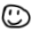
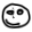
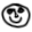
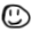
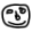
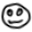
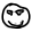
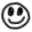
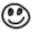
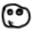
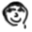
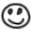
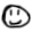
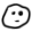
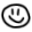
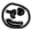
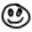
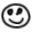
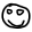
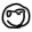


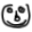
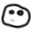
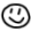
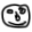
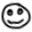
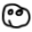
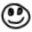
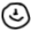
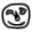
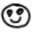
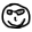
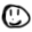
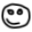
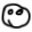
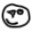
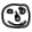
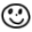
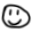
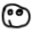
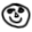
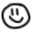
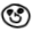
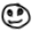
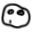
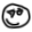
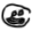
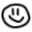
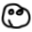
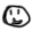
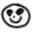
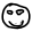
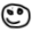
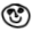
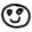
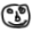
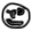
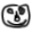
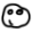
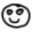
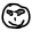
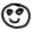
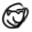
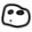
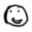
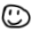
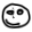
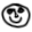
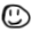
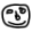
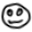
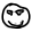
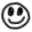
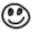
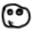
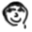
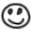
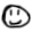
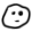
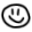
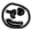
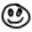
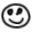
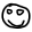
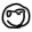

In [62]:
max_images = 4 * 16
bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

### Experimentos

In [29]:
post_pi_n_dict = {}
times_autocorr = {}
total_times = {}

In [28]:
burn = 400
num_samples = 15_000

In [30]:
bar = "=" * 10

for step_p_sample in [1, 2, 3]:
    post_pi_n_dict[step_p_sample] = {}
    times_autocorr[step_p_sample] = {}
    total_times[step_p_sample] = {}
    
    for n_data in [5, 50, 100]:
        post_pi_n_dict[step_p_sample][n_data] = {}
        times_autocorr[step_p_sample][n_data] = {}
        total_times[step_p_sample][n_data] = {}

        for desired_acc_rate in [0.3, 0.6]:
            print(bar + f" {step_p_sample = }, {n_data = }, {desired_acc_rate = } " + bar)
            post_pi_n = NUTSPosteriorPiN(
                n_walkers=8,
                num_steps_per_sample=step_p_sample,
                burn=burn,
                desired_accept_rate=desired_acc_rate,
            )
            post_pi_n.fit(data[:n_data], G, transform_out)
            post_pi_n.run(num_samples=num_samples)

            mean_autocorr_time = int(post_pi_n.get_autocorr_time().mean())
            total_time = post_pi_n.total_time

            post_pi_n_dict[step_p_sample][n_data][desired_acc_rate] = post_pi_n
            times_autocorr[step_p_sample][n_data][desired_acc_rate] = mean_autocorr_time
            total_times[step_p_sample][n_data][desired_acc_rate] = total_time

            print(post_pi_n)
            print(f"{mean_autocorr_time = }")
            print(f"{total_time = }")
            print()
    

========== step_p_sample = 1, n_data = 5, desired_acc_rate = 0.3 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.5507329702377319---- |   390/15400 | 49.93       
0d:00:04:49 | 0d:00:00:00 | #################### | 15400/15400 | 53.21       
Acceptance Rate 0.27
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.4828493893146515---- |   394/15400 | 59.24       
0d:00:04:28 | 0d:00:00:00 | #################### | 15400/15400 | 57.34       
Acceptance Rate 0.29
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.46603915095329285--- |   387/15400 | 60.35       
0d:00:04:38 | 0d:00:00:00 | #################### | 15400/15400 | 55.36       
Acceptance Rate 0.33
Sampling (Sampler.HMC; Integra

2023-10-10 00:55:48,329: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 127 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([635.4317, 704.7411, 618.2607, 450.7021, 552.9042, 530.9573, 544.5089,
        497.4580, 769.6848, 501.8800, 501.9158, 801.7779, 598.2969, 593.5896,
        559.1428, 404.2130, 667.9965, 451.3101, 435.1856, 511.3909, 526.1093,
        731.7565, 624.6953, 563.7685, 526.7653, 440.0412, 580.7302, 540.6912,
        587.9606, 854.4028, 489.2503, 710.9373, 547.5250, 397.8897, 610.0721,
        540.1537, 383.6383, 533.8751, 405.3686, 491.7206, 581.8032, 486.3636,
        451.8787, 502.0825, 602.0043, 585.8924, 573.6935, 608.3611, 751.8115,
        351.1576, 486.2940, 631.0900, 504.2203, 718.1939, 461.9587, 601.5838,
        648.1102, 401.7870, 563.7692, 530.8434, 653.5850, 518.5942, 416.7401,
        282.8337, 554.5402, 715.2983, 437.5145, 561.3188, 517.3309, 416.7724,
     

NUTSPosteriorPiN(n_data=50, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 554
total_time = 2170.074834107014

========== step_p_sample = 1, n_data = 50, desired_acc_rate = 0.6 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.04793831706047058--- |   396/15400 | 56.59       
0d:00:04:14 | 0d:00:00:00 | #################### | 15400/15400 | 60.63       
Acceptance Rate 0.69
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.05185427516698837--- |   392/15400 | 56.29       
0d:00:04:32 | 0d:00:00:00 | #################### | 15400/15400 | 56.61       
Acceptance Rate 0.74
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.08703666925430298--- |

2023-10-10 01:31:01,048: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 833.0594,  900.8087,  718.7599,  661.7040,  761.2079, 1003.5292,
         875.1681,  742.7863,  997.2632,  709.4515,  577.7357, 1209.3628,
         641.2423,  565.2678,  933.5668,  581.2603,  722.6075,  640.5095,
         721.5732,  829.1659,  966.3395, 1057.5830,  969.2581,  577.7012,
         607.3561,  770.9722,  832.6550,  884.0961, 1030.0634,  848.4052,
         737.9476, 1012.9285,  898.8013,  723.5692,  708.7314,  590.5405,
         574.1837,  914.1812,  838.6289,  739.1297,  779.5184,  826.4174,
         602.1086,  716.6661,  791.1251, 1166.6079,  722.4836,  719.1628,
         756.9033,  494.1909,  722.6087,  978.9677,  821.7941,  638.2444,
         861.3085,  926.0302,  982.3885,  616.7447, 1148.7521,  616.1868,
        1072.3983,  706.7803,  661.4290,  771

NUTSPosteriorPiN(n_data=50, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 817
total_time = 2112.062067823019

========== step_p_sample = 1, n_data = 100, desired_acc_rate = 0.3 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.04680071771144867--- |   395/15400 | 61.61       
0d:00:04:19 | 0d:00:00:00 | #################### | 15400/15400 | 59.38       
Acceptance Rate 0.40
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.15875400602817535--- |   392/15400 | 46.79       
0d:00:04:37 | 0d:00:00:00 | #################### | 15400/15400 | 55.57       
Acceptance Rate 0.18
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.08877205848693848--- 

2023-10-10 02:06:39,013: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 603.6324,  483.1297,  864.7651,  678.8744,  865.1161,  548.5764,
         579.7537,  725.5749,  769.4125,  757.8959,  620.2302,  873.4106,
         584.5991,  766.0164,  931.9008,  537.1162,  829.2805,  735.9785,
         541.7607,  811.0874,  636.7401,  829.1650,  823.2803, 1070.5676,
         672.6534,  835.9482,  707.7476,  838.7944,  685.2043,  859.3521,
         591.3331,  678.3250,  826.1743,  916.7916,  626.2973,  518.8933,
         410.1165,  789.7187,  703.5599,  605.9738,  873.3049,  660.3071,
        1075.2916,  540.6290,  916.5405,  839.5168,  882.0009,  886.5244,
         825.6946,  549.8972,  439.9735,  941.7628,  884.3733,  991.6987,
         609.3883,  601.3828,  796.1716,  563.0892,  725.5703,  741.9789,
         872.3464,  596.1031,  587.4212,  604

NUTSPosteriorPiN(n_data=100, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 725
total_time = 2137.058659125032

========== step_p_sample = 1, n_data = 100, desired_acc_rate = 0.6 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.028377382084727287-- |   390/15400 | 60.80       
0d:00:04:29 | 0d:00:00:00 | #################### | 15400/15400 | 57.10       
Acceptance Rate 0.73
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.03755306452512741--- |   398/15400 | 55.12       
0d:00:04:55 | 0d:00:00:00 | #################### | 15400/15400 | 52.11       
Acceptance Rate 0.68
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.03977411985397339---

2023-10-10 02:42:13,855: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 886.2900, 1339.2780, 1234.3798, 1188.6001, 1511.1669, 1449.7649,
        1155.5900, 1103.6825, 1271.5637, 1110.1462,  780.6095, 1454.8678,
        1323.7415, 1394.1162, 1260.0703,  854.5612, 1019.7729, 1045.5010,
         814.2689, 1110.3688, 1328.3282, 1318.7582, 1098.7833, 1246.1919,
        1556.9651, 1119.0366, 1483.3673, 1268.5433, 1402.7825, 1214.7843,
        1004.7388, 1464.7916, 1261.7522, 1087.7307, 1608.7218,  743.7042,
        1087.4445, 1242.8871, 1012.3876, 1329.5635, 1062.5758, 1128.8381,
        1446.0496, 1222.4011, 1277.4944, 1360.7169,  951.4374, 1109.3462,
        1299.3077,  955.9693, 1106.5237, 1193.8958, 1344.5500, 1153.9642,
        1207.0153, 1159.5457, 1005.3325, 1142.2626, 1087.2352, 1082.3439,
        1056.6382, 1150.7784, 1145.9701, 1266

NUTSPosteriorPiN(n_data=100, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 1199
total_time = 2134.2023749650107

========== step_p_sample = 2, n_data = 5, desired_acc_rate = 0.3 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.22215700149536133--- |   399/15400 | 49.38       
0d:00:05:31 | 0d:00:00:00 | #################### | 15400/15400 | 46.49       
Acceptance Rate 0.37
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.15363241732120514--- |   395/15400 | 37.76       
0d:00:05:38 | 0d:00:00:00 | #################### | 15400/15400 | 45.50       
Acceptance Rate 0.48
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.22382542490959167---

2023-10-10 04:12:24,715: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([183.5036, 161.8970, 203.3759, 188.7926, 220.3216, 143.9039, 196.0835,
        169.5429, 300.0728, 195.9225, 232.0773, 227.6910, 186.6125, 234.2954,
        188.1262, 177.3260, 221.0310, 221.1111, 154.0936, 172.7694, 134.7091,
        265.3837, 234.5063, 195.7079, 214.9292, 273.0467, 148.3125, 208.3929,
        199.4741, 242.1920, 186.1457, 203.9288, 206.8710, 243.7399, 200.9419,
        187.9513, 207.9446, 194.8733, 188.1105, 198.7839, 221.3573, 169.5403,
        225.8708, 237.7504, 177.7708, 178.4294, 175.8098, 195.5409, 314.4506,
        189.8887, 245.9276, 257.2119, 259.8077, 241.8026, 197.3488, 187.8388,
        228.5185, 229.3806, 252.5959, 162.6790, 154.2335, 280.5343, 231.2024,
        174.8931, 208.9369, 219.5960, 229.9532, 216.3500, 173.0531, 188.5009,
       

NUTSPosteriorPiN(n_data=5, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 210
total_time = 2738.5646716139745

========== step_p_sample = 2, n_data = 50, desired_acc_rate = 0.3 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.10506107658147812--- |   399/15400 | 35.12       
0d:00:05:54 | 0d:00:00:00 | #################### | 15400/15400 | 43.44       
Acceptance Rate 0.18
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.10069011151790619--- |   398/15400 | 51.12       
0d:00:06:11 | 0d:00:00:00 | #################### | 15400/15400 | 41.46       
Acceptance Rate 0.22
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.1099231094121933---- |

2023-10-10 04:58:28,435: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 124 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([525.7592, 427.5168, 352.8831, 355.5922, 394.7631, 413.9164, 371.0556,
        486.4298, 402.9154, 410.9947, 379.4362, 459.4544, 506.6933, 350.1484,
        489.4404, 541.5045, 472.7764, 338.5665, 372.3564, 421.5877, 439.9670,
        500.6886, 555.2823, 484.3025, 631.0181, 469.0198, 362.2508, 314.5076,
        343.0934, 529.8873, 540.3083, 501.3468, 470.3477, 368.0930, 600.3684,
        301.7496, 364.2792, 423.5770, 365.8801, 457.9753, 457.4945, 356.7594,
        440.7234, 368.3297, 694.6338, 491.0801, 270.5997, 530.5054, 554.5846,
        375.4465, 428.7914, 396.4770, 350.8449, 468.8094, 425.4934, 339.0468,
        410.5284, 345.9057, 325.5624, 294.9825, 628.3323, 312.7139, 505.3962,
        452.3028, 539.6826, 315.7942, 427.6611, 332.3151, 376.8816, 561.4106,
     

NUTSPosteriorPiN(n_data=50, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 433
total_time = 2762.9876465119887

========== step_p_sample = 2, n_data = 50, desired_acc_rate = 0.6 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.027169715613126755-- |   396/15400 | 36.94       
0d:00:05:55 | 0d:00:00:00 | #################### | 15400/15400 | 43.30       
Acceptance Rate 0.68
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.04759985953569412--- |   399/15400 | 50.23       
0d:00:05:35 | 0d:00:00:00 | #################### | 15400/15400 | 45.90       
Acceptance Rate 0.52
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.02614923194050789--- 

2023-10-10 05:44:09,955: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 674.3591, 1144.3846,  882.7946,  679.2598,  940.3535, 1310.0175,
         838.2720,  648.9846,  694.9738,  616.7899,  601.9918, 1118.8655,
         754.1202,  609.3657,  874.6105,  894.6596,  880.5822,  578.6649,
         726.3946,  831.1443,  926.0737, 1161.2279,  914.2931,  716.6144,
        1001.7603,  765.4493,  726.1492,  852.0637,  820.9111, 1049.8119,
         714.8175,  896.3328, 1063.5576,  699.5929, 1088.6362,  586.6580,
         583.6016,  803.1835,  586.1754,  735.3849,  998.5758,  869.2769,
         812.3009,  668.9895, 1149.3298, 1097.2509,  792.3613,  737.7761,
        1062.2745,  504.5915,  858.3574,  909.7877,  948.8942,  523.0463,
         896.1047, 1009.2879,  886.3512,  587.8812,  939.0983,  894.9177,
         967.2732,  684.1163,  607.0689,  776

NUTSPosteriorPiN(n_data=50, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 850
total_time = 2740.801775644999

========== step_p_sample = 2, n_data = 100, desired_acc_rate = 0.3 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.07661809027194977--- |   393/15400 | 40.44       
0d:00:05:58 | 0d:00:00:00 | #################### | 15400/15400 | 42.91       
Acceptance Rate 0.16
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.020981617271900177-- |   396/15400 | 43.50       
0d:00:05:28 | 0d:00:00:00 | #################### | 15400/15400 | 46.82       
Acceptance Rate 0.62
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.0858263447880745---- 

2023-10-10 06:30:05,986: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 821.9509,  504.3770,  705.7209,  745.5944,  873.7616,  723.9075,
         632.5172,  645.6880,  758.1919,  651.5679,  606.4516,  669.7789,
         749.5450,  662.1010,  760.0546,  433.1098,  911.7651,  485.4464,
         534.7555,  765.0352,  719.6807,  788.5364,  608.6085,  741.6537,
         685.2816,  728.3817,  782.3729,  617.3138,  684.4108,  512.4053,
         575.2578,  741.7789,  503.7555,  856.2424,  635.5589,  538.5362,
         575.0745,  908.8263,  505.2690,  880.8602,  717.7549,  806.1603,
         572.3759,  798.7808,  690.5842,  790.2310,  596.5057,  599.1160,
        1011.2175,  514.9911,  893.7814,  866.3673,  551.3560,  711.9015,
         581.6035,  899.9775,  558.9526,  569.7015,  494.6529,  640.1686,
         938.3241,  982.5703,  779.9418,  520

NUTSPosteriorPiN(n_data=100, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 711
total_time = 2755.060869482986

========== step_p_sample = 2, n_data = 100, desired_acc_rate = 0.6 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.02876380644738674--- |   397/15400 | 45.12       
0d:00:05:59 | 0d:00:00:00 | #################### | 15400/15400 | 42.88       
Acceptance Rate 0.61
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.029521409422159195-- |   400/15400 | 36.59       
0d:00:05:43 | 0d:00:00:00 | #################### | 15400/15400 | 44.82       
Acceptance Rate 0.55
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.03977057337760925---

2023-10-10 07:15:26,584: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([1026.6221,  967.8454,  911.0794, 1017.9834, 1275.5581, 1141.9785,
         974.1064,  975.1364, 1098.3344, 1088.9047,  773.1415, 1399.4912,
         960.6689,  985.4733, 1196.4331,  729.2545, 1052.3472, 1133.1461,
         744.3170, 1056.3583,  993.8946, 1142.5751, 1066.7136,  815.5233,
         917.9294,  881.0629,  725.0229, 1199.4913,  918.6387, 1343.7043,
         738.8697, 1021.8614, 1211.6923,  970.2504, 1499.4552,  607.2667,
         734.8781,  910.9724, 1026.1296, 1209.6914,  868.8544,  866.3979,
         971.5474, 1170.3507,  970.2597, 1217.8508,  834.4835,  690.9765,
        1118.1742,  789.7828,  820.5380,  915.8365, 1257.1993,  837.3764,
        1074.7229, 1088.6279,  875.7164, 1075.5149,  896.6050, 1173.1580,
        1096.1005,  832.6296, 1182.9508,  957

NUTSPosteriorPiN(n_data=100, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 1001
total_time = 2719.876295117021

========== step_p_sample = 3, n_data = 5, desired_acc_rate = 0.3 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.14772671461105347--- |   397/15400 | 35.83       
0d:00:06:49 | 0d:00:00:00 | #################### | 15400/15400 | 37.61       
Acceptance Rate 0.36
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.08017119020223618--- |   391/15400 | 39.84       
0d:00:06:37 | 0d:00:00:00 | #################### | 15400/15400 | 38.70       
Acceptance Rate 0.57
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.17388837039470673--- 

2023-10-10 10:08:09,127: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 460.3600,  529.8768,  646.4567,  586.1390,  579.5871,  438.2262,
         368.5695,  456.3995,  581.9897,  385.1891,  385.7771,  523.6784,
         509.5898,  761.9508,  485.5686,  392.8059, 1043.2976,  567.2778,
         410.8398,  569.5322,  405.3799,  804.5671,  617.2785,  368.1822,
         384.3215,  584.3636,  679.3019,  483.7378,  466.8408,  473.3996,
         541.5012,  476.7304,  531.5703,  550.9243,  404.1697,  458.0240,
         435.8698,  539.3795,  318.5658,  719.0725,  437.9318,  411.7293,
         419.0981,  482.3004,  487.2618,  548.3662,  477.3474,  581.5713,
         344.2876,  540.5629,  520.9167,  376.1593,  637.5807,  420.3878,
         432.9790,  601.2906,  493.1220,  402.9115,  749.2958,  372.4769,
         508.1274,  468.4452,  503.7460,  512

NUTSPosteriorPiN(n_data=50, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 522
total_time = 3524.7406491899746

========== step_p_sample = 3, n_data = 50, desired_acc_rate = 0.6 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.016436001285910606-- |   395/15400 | 37.76       
0d:00:07:25 | 0d:00:00:00 | #################### | 15400/15400 | 34.53       
Acceptance Rate 0.72
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.025357561185956----- |   396/15400 | 34.14       
0d:00:07:16 | 0d:00:00:00 | #################### | 15400/15400 | 35.32       
Acceptance Rate 0.62
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.02305968850851059--- 

2023-10-10 11:07:12,402: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 998.7489,  887.7905,  661.6212,  597.0196,  770.4550,  698.8644,
         763.7830,  788.1432,  702.7021,  679.3026,  591.3000,  967.5697,
         702.7885,  612.7582,  824.3815,  527.9059,  823.5165,  669.3056,
         853.3735,  731.9070,  805.9550, 1052.8175,  653.8016,  662.6844,
         694.8927,  891.9093,  515.9092,  630.1813,  799.3499,  709.8645,
         634.2607,  970.9319,  721.8947,  709.3408,  737.7927,  652.3000,
         541.4957,  714.0366,  548.5622,  609.8746,  953.4335,  709.4528,
         530.4908,  673.7107,  903.3743,  849.9250,  695.3636,  498.0145,
         560.0073,  491.6979,  836.4294,  777.4315,  797.9865,  534.6379,
         569.2091,  727.7819,  680.2253,  574.3129,  663.2206,  719.7432,
         959.3652,  743.7265,  638.1450,  644

NUTSPosteriorPiN(n_data=50, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 751
total_time = 3542.430918566999

========== step_p_sample = 3, n_data = 100, desired_acc_rate = 0.3 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.049693763256073----- |   392/15400 | 35.00       
0d:00:07:08 | 0d:00:00:00 | #################### | 15400/15400 | 35.97       
Acceptance Rate 0.21
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.0592336431145668---- |   394/15400 | 28.39       
0d:00:07:03 | 0d:00:00:00 | #################### | 15400/15400 | 36.37       
Acceptance Rate 0.13
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.025518115609884262-- 

2023-10-10 12:03:33,778: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 845.9737,  520.9272,  555.9827,  995.5154,  714.1775,  562.4926,
         489.5701,  833.6656,  529.8630,  709.4435,  519.7746,  694.1207,
         798.5881,  555.3149,  540.9175,  474.6339,  788.1100,  602.9755,
         566.9015,  639.2822,  387.4910,  755.4042,  877.9946,  834.6518,
         738.3655,  525.9663,  485.0836,  396.9943,  869.8510,  567.5770,
         731.5979,  725.6027,  704.3704,  716.6002,  683.9229,  574.4752,
         848.9197,  914.4100,  452.8174,  467.4127,  502.1144,  446.5745,
         757.3153,  482.9015, 1184.8947,  733.7590,  623.0688,  529.2980,
         919.2979,  495.9061,  569.1313,  471.6173,  557.7180,  595.5350,
         521.3807,  633.6833,  629.0253,  594.5910,  820.1107,  416.7802,
         786.6756,  671.2460,  602.0987,  542

NUTSPosteriorPiN(n_data=100, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 656
total_time = 3380.6232274069916

========== step_p_sample = 3, n_data = 100, desired_acc_rate = 0.6 ==========
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.022360151633620262-- |   397/15400 | 33.54       
0d:00:07:12 | 0d:00:00:00 | #################### | 15400/15400 | 35.59       
Acceptance Rate 0.57
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.019041741266846657-- |   398/15400 | 32.32       
0d:00:07:12 | 0d:00:00:00 | #################### | 15400/15400 | 35.61       
Acceptance Rate 0.57
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.008470414206385612-

2023-10-10 12:59:55,589: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([1145.4967, 1231.4427,  976.1584,  952.7211, 1164.3209, 1187.8953,
        1086.9094,  944.8959,  979.9980,  860.6540,  802.4534, 1409.2164,
        1172.3903, 1162.5485, 1319.8600,  704.2787, 1147.1484, 1054.1685,
         965.8486, 1070.3157, 1060.1792, 1219.2743, 1080.6888,  887.0712,
         934.0676,  954.9895,  771.4211, 1529.6858, 1075.3057, 1105.0624,
         980.0463, 1175.7189, 1208.9545, 1337.0646, 1432.2678, 1001.7740,
         631.9636, 1119.3417, 1197.2006, 1127.3969, 1038.4692,  954.4359,
        1349.6218,  845.9935, 1162.9825, 1524.3687,  908.9567, 1062.7074,
        1146.3926,  994.9724, 1017.3247,  843.9686, 1305.2809, 1002.9035,
        1136.3485, 1208.2263,  846.2012, 1105.1758, 1126.4946, 1245.1758,
         995.2075,  865.5654,  858.9841, 1153

NUTSPosteriorPiN(n_data=100, n_total_iterations=15000, n_workers=None, n_walkers=8, parallel=False)
mean_autocorr_time = 1085
total_time = 3380.914592319983



Se demoró 13.85 horas en correr la celda anterior.

In [82]:
for n_data in [5, 50, 100]:
    for desired_acc_rate in [0.6, 0.3]:
        for step_p_sample in [1, 2, 3]:    
            print(bar + f" {step_p_sample = }, {n_data = }, {desired_acc_rate = } " + bar)
            # print(post_pi_n_dict[step_p_sample][n_data][desired_acc_rate])
            print(f"autocorr time: {times_autocorr[step_p_sample][n_data][desired_acc_rate]}")
            print(f"time spend: {total_times[step_p_sample][n_data][desired_acc_rate]/60:.2f} mins")
            print()
        print()
    print(bar*8 + "\n")

========== step_p_sample = 1, n_data = 5, desired_acc_rate = 0.6 ==========
autocorr time: 129
time spend: 35.49 mins

========== step_p_sample = 2, n_data = 5, desired_acc_rate = 0.6 ==========
autocorr time: 210
time spend: 45.64 mins

========== step_p_sample = 3, n_data = 5, desired_acc_rate = 0.6 ==========
autocorr time: 140
time spend: 58.28 mins


========== step_p_sample = 1, n_data = 5, desired_acc_rate = 0.3 ==========
autocorr time: 52
time spend: 36.12 mins

========== step_p_sample = 2, n_data = 5, desired_acc_rate = 0.3 ==========
autocorr time: 54
time spend: 44.51 mins

========== step_p_sample = 3, n_data = 5, desired_acc_rate = 0.3 ==========
autocorr time: 58
time spend: 55.65 mins



========== step_p_sample = 1, n_data = 50, desired_acc_rate = 0.6 ==========
autocorr time: 817
time spend: 35.20 mins

========== step_p_sample = 2, n_data = 50, desired_acc_rate = 0.6 ==========
autocorr time: 850
time spend: 45.68 mins

========== step_p_sample = 3, n_data = 50, des

Aquí tomamos aquellas cadenas que tuvieron un tiempo de autocorrelación menor.

In [46]:
post_pi_n_5 = post_pi_n_dict[1][5][0.3]
post_pi_n_50 = post_pi_n_dict[2][50][0.3]
post_pi_n_100 = post_pi_n_dict[3][100][0.3]

Obtenemos sus tiempos de autocorrelación promedios

In [50]:
mean_autocorr_time_n_5 = int(post_pi_n_5.get_autocorr_time().mean())
print(f"{mean_autocorr_time_n_5 = }")

mean_autocorr_time_n_50 = int(post_pi_n_50.get_autocorr_time().mean())
print(f"{mean_autocorr_time_n_50 = }")

mean_autocorr_time_n_100 = int(post_pi_n_100.get_autocorr_time().mean())
print(f"{mean_autocorr_time_n_100 = }")

mean_autocorr_time_n_5 = 52


2023-10-10 14:50:11,142: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 124 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([525.7592, 427.5168, 352.8831, 355.5922, 394.7631, 413.9164, 371.0556,
        486.4298, 402.9154, 410.9947, 379.4362, 459.4544, 506.6933, 350.1484,
        489.4404, 541.5045, 472.7764, 338.5665, 372.3564, 421.5877, 439.9670,
        500.6886, 555.2823, 484.3025, 631.0181, 469.0198, 362.2508, 314.5076,
        343.0934, 529.8873, 540.3083, 501.3468, 470.3477, 368.0930, 600.3684,
        301.7496, 364.2792, 423.5770, 365.8801, 457.9753, 457.4945, 356.7594,
        440.7234, 368.3297, 694.6338, 491.0801, 270.5997, 530.5054, 554.5846,
        375.4465, 428.7914, 396.4770, 350.8449, 468.8094, 425.4934, 339.0468,
        410.5284, 345.9057, 325.5624, 294.9825, 628.3323, 312.7139, 505.3962,
        452.3028, 539.6826, 315.7942, 427.6611, 332.3151, 376.8816, 561.4106,
     

mean_autocorr_time_n_50 = 433


2023-10-10 14:50:11,962: WARNING [__main__:135]
> The chain is shorter than 50 times the integrated autocorrelation time for 128 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: tensor([ 845.9737,  520.9272,  555.9827,  995.5154,  714.1775,  562.4926,
         489.5701,  833.6656,  529.8630,  709.4435,  519.7746,  694.1207,
         798.5881,  555.3149,  540.9175,  474.6339,  788.1100,  602.9755,
         566.9015,  639.2822,  387.4910,  755.4042,  877.9946,  834.6518,
         738.3655,  525.9663,  485.0836,  396.9943,  869.8510,  567.5770,
         731.5979,  725.6027,  704.3704,  716.6002,  683.9229,  574.4752,
         848.9197,  914.4100,  452.8174,  467.4127,  502.1144,  446.5745,
         757.3153,  482.9015, 1184.8947,  733.7590,  623.0688,  529.2980,
         919.2979,  495.9061,  569.1313,  471.6173,  557.7180,  595.5350,
         521.3807,  633.6833,  629.0253,  594.5910,  820.1107,  416.7802,
         786.6756,  671.2460,  602.0987,  542

mean_autocorr_time_n_100 = 656


Ahora haremos muestreos utilizando el tiempo de autocorrelación por cada cadena.

In [57]:
post_pi_n_5.shuffle_samples_cache(thin=mean_autocorr_time_n_5)

NUTSPosteriorPiN(n_data=5, n_total_iterations=15000, n_cached_samples=2312, n_workers=None, n_walkers=8, parallel=False)

In [58]:
post_pi_n_50.shuffle_samples_cache(thin=mean_autocorr_time_n_50)

NUTSPosteriorPiN(n_data=50, n_total_iterations=15000, n_cached_samples=280, n_workers=None, n_walkers=8, parallel=False)

In [60]:
post_pi_n_100.shuffle_samples_cache(thin=mean_autocorr_time_n_100)

NUTSPosteriorPiN(n_data=100, n_total_iterations=15000, n_cached_samples=184, n_workers=None, n_walkers=8, parallel=False)

Y visualizaremos los resultados.


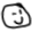
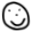
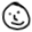
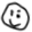
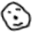
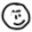
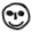
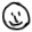
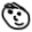
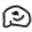
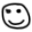
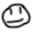
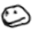
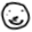
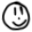
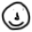
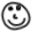
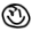
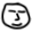
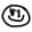
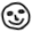
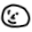
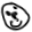
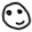
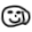
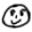
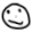
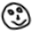
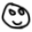
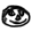
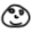
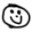
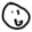
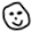
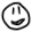
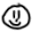
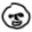
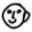
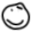
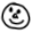
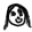
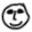
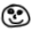
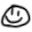
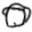
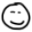
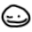
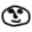
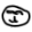
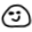
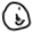
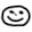
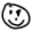
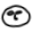
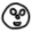
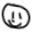
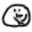
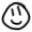
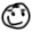
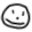
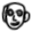
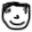
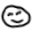
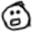


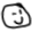
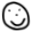
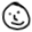
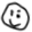
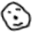
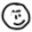
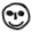
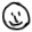
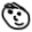
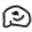
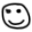
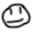
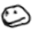
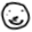
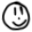
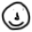
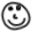
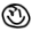
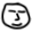
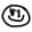
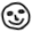
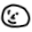
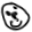
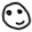
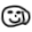
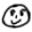
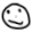
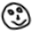
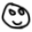
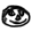
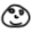
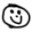
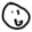
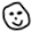
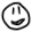
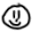
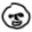
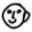
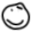
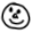
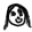
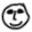
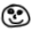
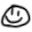
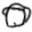
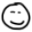
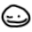
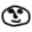
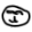
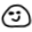
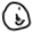
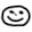
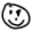
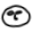
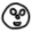
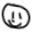
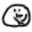
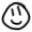
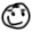
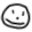
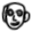
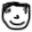
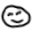
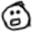

In [62]:
max_images = 4 * 16
bwb_utils.plot_list_of_draws(post_pi_n_5.rvs(max_images), max_images=max_images)


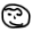
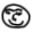
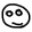
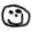
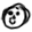
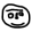
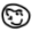
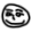
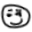
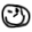
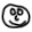
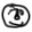
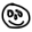
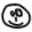
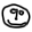
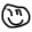
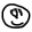
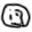
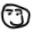
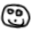
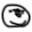
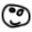
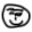
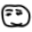
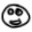
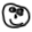
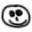
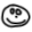
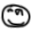
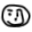
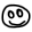
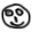
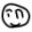
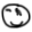
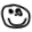
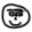
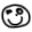
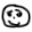
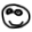
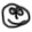
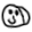
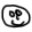
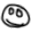
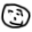
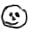
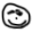
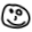
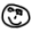
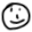
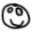
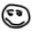
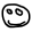
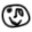
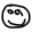
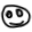
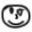
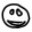
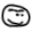
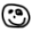
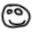
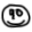
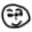
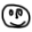
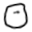


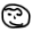
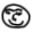
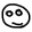
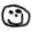
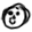
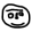
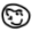
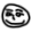
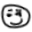
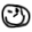
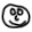
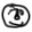
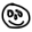
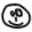
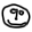
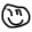
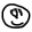
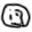
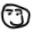
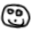
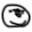
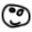
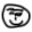
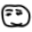
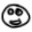
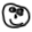
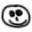
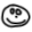
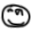
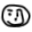
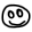
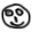
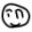
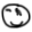
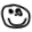
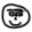
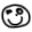
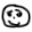
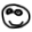
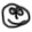
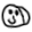
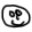
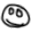
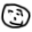
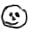
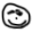
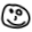
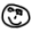
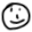
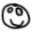
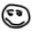
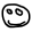
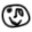
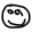
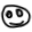
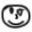
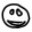
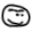
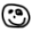
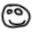
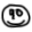
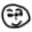
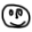
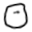

In [63]:
bwb_utils.plot_list_of_draws(post_pi_n_50.rvs(max_images), max_images=max_images)


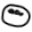
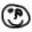
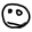
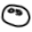
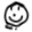
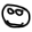
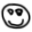
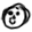
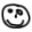
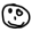
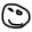
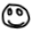
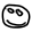
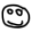
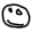
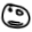
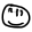
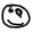
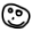
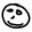
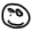
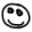
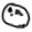
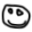
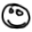
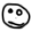
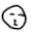
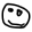
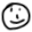
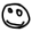
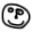
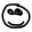
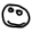
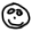
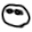
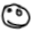
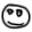
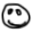
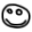
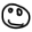
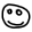
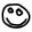
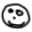
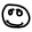
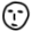
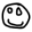
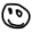
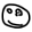
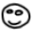
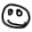
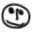
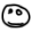
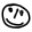
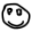
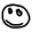
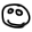
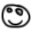
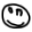
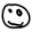
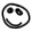
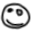
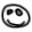
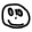
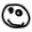


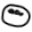
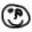
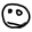
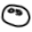
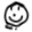
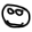
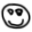
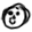
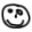
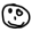
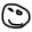
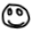
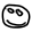
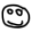
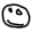
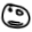
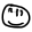
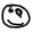
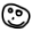
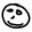
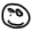
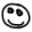
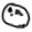
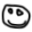
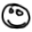
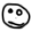
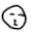
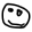
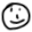
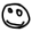
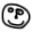
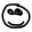
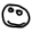
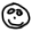
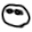
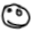
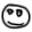
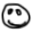
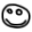
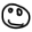
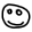
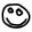
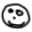
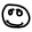
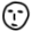
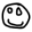
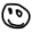
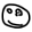
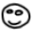
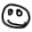
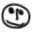
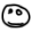
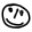
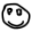
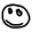
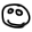
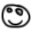
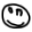
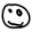
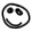
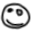
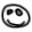
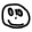
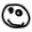

In [64]:
bwb_utils.plot_list_of_draws(post_pi_n_100.rvs(max_images), max_images=max_images)

In [72]:
face0

## Hamiltonian Monte Carlo (HMC)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 46/46 | 30.79       
Acceptance Rate 0.37



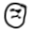
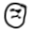
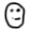
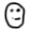
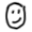
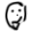
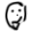
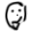
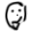
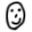
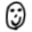
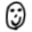
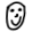
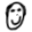
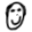
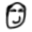
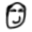
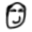
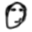
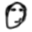
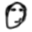
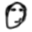
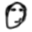
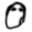
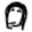
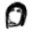
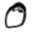
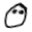
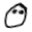
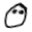
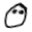
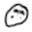
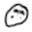
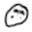
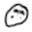
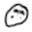


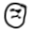
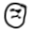
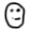
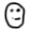
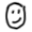
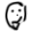
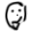
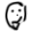
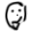
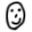
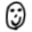
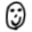
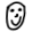
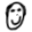
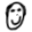
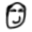
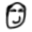
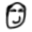
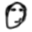
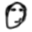
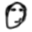
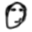
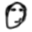
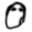
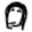
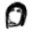
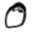
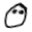
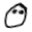
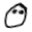
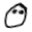
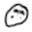
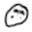
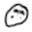
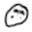
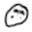

HMCPosteriorPiN(n_data=5, n_total_samples=36)
1.6800036599961459


In [21]:
class HMCPosteriorPiN(LatentMCMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior,
            num_samples=10, 
            num_steps_per_sample=5, 
            burn=10,
            step_size=0.1, 
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            sampler=Sampler.HMC,
            **kwargs
        )

post_pi_n = HMCPosteriorPiN()
post_pi_n.fit(data[:5], G, transform_out)

max_images = 4 * 9
post_pi_n.reset_samples().run(num_samples=max_images)

bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

print(post_pi_n)
print(post_pi_n.total_time)

## Riemannian Manifold Hamiltonian Monte Carlo (RMHMC)

In [81]:
class RMHMCPosteriorPiN(LatentMCMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior,
            num_samples=10, 
            num_steps_per_sample=5, 
            burn=10,
            step_size=0.1, 
            fixed_point_max_iterations=1000,
            fixed_point_threshold=1e-5,
            explicit_binding_const=100,
            integrator=Integrator.IMPLICIT,
            metric=Metric.HESSIAN,
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            fixed_point_max_iterations=fixed_point_max_iterations,
            fixed_point_threshold=fixed_point_threshold,
            explicit_binding_const=explicit_binding_const,
            sampler=Sampler.RMHMC,
            integrator=integrator,
            metric=metric,
            **kwargs
        )

    def _additional_repr_(self, sep):
        to_return = super()._additional_repr_(sep)
        to_return += f"metric={self.hamiltorch_kwargs['metric'].name}" + sep
        return to_return
    
post_pi_n = RMHMCPosteriorPiN(step_size=step_size)
post_pi_n

RMHMCPosteriorPiN(metric=HESSIAN)

### Implicit RMHMC

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:39 | 0d:00:00:00 | #################### | 46/46 | 1.21       
Acceptance Rate 0.63



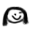
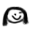
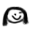
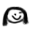
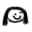
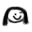
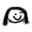
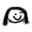
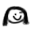
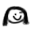
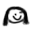
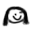
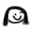
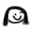
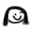
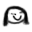
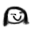
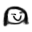
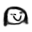
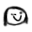
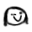
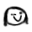
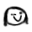
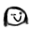
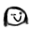
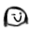
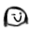
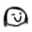
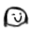
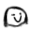
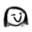
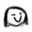
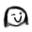
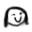
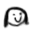
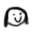


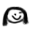
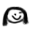
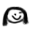
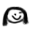
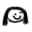
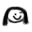
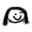
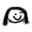
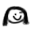
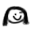
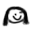
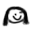
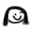
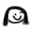
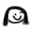
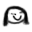
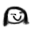
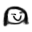
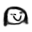
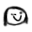
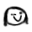
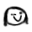
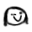
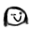
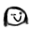
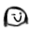
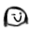
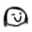
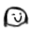
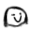
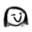
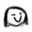
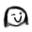
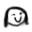
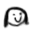
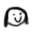

ImplicitRMHMCPosteriorPiN(n_data=5, n_total_samples=36, metric=HESSIAN, fixed_point_max_iterations=1000, fixed_point_threshold=1e-05)
39.46778077899944


In [82]:
class ImplicitRMHMCPosteriorPiN(RMHMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior, 
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1, 
            fixed_point_max_iterations=1000,
            fixed_point_threshold=1e-5,
            metric=Metric.HESSIAN,
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            integrator=Integrator.IMPLICIT,
            metric=metric,
            fixed_point_max_iterations=fixed_point_max_iterations,
            fixed_point_threshold=fixed_point_threshold,
            **kwargs
        )

    def _additional_repr_(self, sep):
        to_return = super()._additional_repr_(sep)
        to_return += f"fixed_point_max_iterations={self.hamiltorch_kwargs['fixed_point_max_iterations']}" + sep
        to_return += f"fixed_point_threshold={self.hamiltorch_kwargs['fixed_point_threshold']}" + sep
        return to_return

        
post_pi_n = ImplicitRMHMCPosteriorPiN(num_steps_per_sample=1)
post_pi_n.fit(data[:5], G, transform_out)

max_images = 4 * 9
num_samples = max_images
post_pi_n.reset_samples().run(num_samples=num_samples)


bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

print(post_pi_n)
print(post_pi_n.total_time)

### Explicit RMHMC

Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:05:58 | 0d:00:00:00 | #################### | 46/46 | 0.13       
Acceptance Rate 0.22



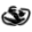
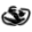
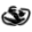
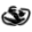
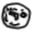
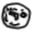
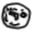
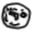
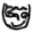
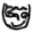
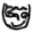
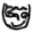
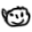
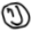
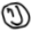
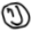
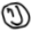
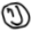
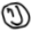
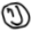
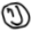
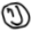
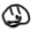
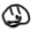
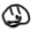
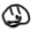
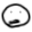
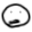
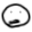
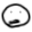
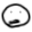
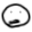
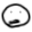
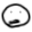
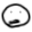
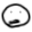


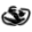
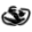
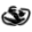
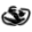
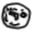
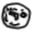
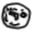
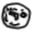
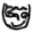
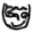
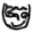
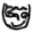
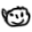
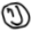
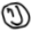
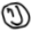
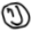
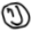
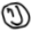
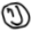
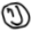
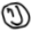
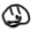
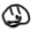
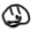
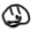
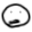
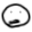
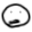
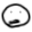
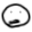
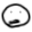
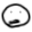
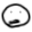
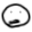
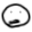

ExplicitRMHMCPosteriorPiN(n_data=5, n_total_samples=36, metric=HESSIAN, explicit_binding_const=100)
358.25699423299375


In [24]:
class ExplicitRMHMCPosteriorPiN(RMHMCPosteriorPiN):
    def __init__(
            self, 
            log_prob_fn=_log_posterior, 
            num_samples=10, 
            num_steps_per_sample=10, 
            burn=10,
            step_size=0.1, 
            explicit_binding_const=100,
            metric=Metric.HESSIAN,
            **kwargs
        ) -> None:
        super().__init__(
            log_prob_fn=log_prob_fn,
            num_samples=num_samples,
            num_steps_per_sample=num_steps_per_sample,
            burn=burn,
            step_size=step_size,
            integrator=Integrator.EXPLICIT,
            metric=metric,
            explicit_binding_const=explicit_binding_const,
            **kwargs
        )

    def _additional_repr_(self, sep):
        to_return = super()._additional_repr_(sep)
        to_return += f"explicit_binding_const={self.hamiltorch_kwargs['explicit_binding_const']}" + sep
        return to_return

        
post_pi_n = ExplicitRMHMCPosteriorPiN()
post_pi_n.fit(data[:5], G, transform_out)

max_images = 4 * 9
post_pi_n.reset_samples().run(num_samples=max_images)


bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

print(post_pi_n)
print(post_pi_n.total_time)

# Experimentos

In [25]:
import traceback


def mcmc_experiment(data, num_steps_per_sample, burn=50, G=G, transform_out=transform_out, max_images=4*9):
    try:
        post_pi_n = NUTSPosteriorPiN(burn=burn, num_steps_per_sample=num_steps_per_sample, desired_accept_rate=0.3)
        post_pi_n.fit(data, G, transform_out)

        post_pi_n.reset_samples().run(num_samples=max_images)

        bwb_utils.plot_list_of_draws(post_pi_n.rvs(max_images), max_images=max_images)

        print(f"{post_pi_n = }")
        print(f"{post_pi_n.total_time = :.4f}")
    except:
        traceback.print_exc()

## Num steps per sample = 10

In [26]:
num_steps_ps = 10

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: -inf, params: tensor([-9.1347e+19,  1.0690e+19, -1.0814e+20, -5.8279e+19,  2.2210e+20,
        -5.2958e+19,  9.2956e+19,  7.7973e+19,  9.1320e+19, -5.0466e+19,
         8.1530e+19,  1.0804e+20,  1.2859e+20,  7.5555e+19,  1.0153e+20,
         8.3185e+19, -9.0650e+19, -8.2898e+19, -1.6399e+19, -1.0549e+20,
        -1.1612e+20,  9.5250e+19, -6.7114e+18, -1.4381e+20,  8.5749e+19,
        -3.3366e+19, -1.9662e+20, -1.1429e+19,  4.8046e+19,  9.6364e+19,
        -2.4192e+19,  8.0702e+19, -2.6134e+19,  1.8467e+20, -5.1753e+17,
         9.2168e+18, -2.2344e+20, -1.5178e+20, -2.4619e+19, -4.7930e+19,
         1.3014e+20, -2.5767e+19, -2.6619e+20,  1.6134e+19, -4.4289e+19,
        -1.5196e+19, -1.1998e+20, -3.6631e+19,  6.3764e+19,  1.2470e+20,
        -3.7042e+19,  7.8679e+19, -4.3968e+19,  1.3702e+20, -9.1717e+19,
         7.7853e+19,  1.6384e+20,  5.0226e+17, -


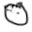
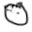
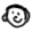
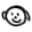
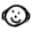
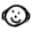
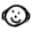
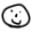
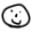
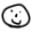
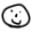
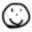
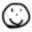
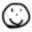
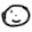
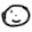
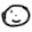
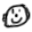
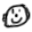
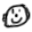
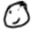
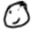
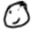
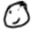
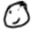
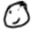
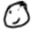
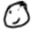
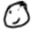
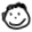
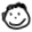
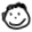
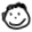
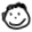
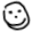
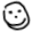


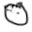
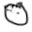
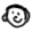
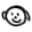
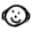
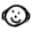
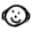
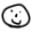
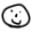
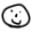
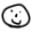
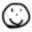
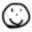
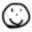
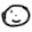
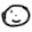
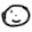
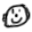
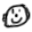
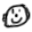
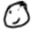
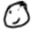
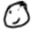
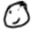
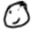
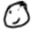
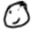
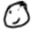
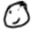
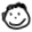
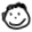
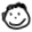
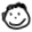
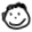
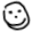
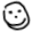

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 4.5769


In [27]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.08853427320718765--- | 46/86 | 19.79       
0d:00:00:04 | 0d:00:00:00 | #################### | 86/86 | 19.88       
Acceptance Rate 0.22



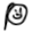
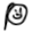
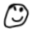
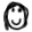
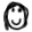
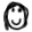
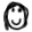
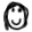
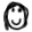
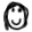
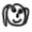
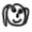
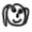
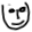
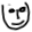
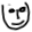
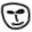
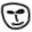
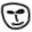
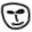
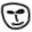
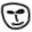
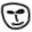
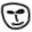
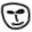
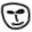
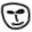
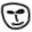
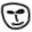
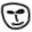
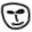
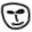
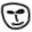
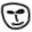
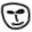
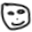


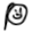
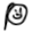
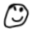
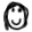
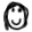
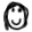
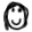
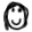
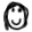
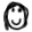
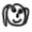
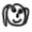
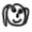
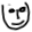
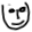
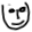
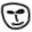
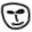
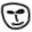
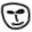
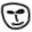
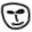
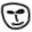
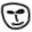
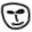
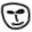
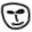
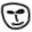
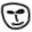
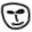
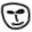
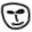
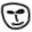
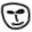
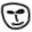
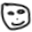

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 4.5230


In [28]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.031092653051018715-- | 49/86 | 18.16       
0d:00:00:04 | 0d:00:00:00 | #################### | 86/86 | 18.76       
Acceptance Rate 0.29



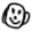
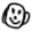
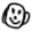
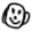
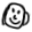
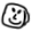
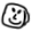
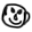
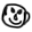
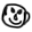
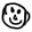
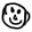
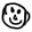
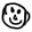
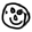
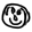
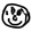
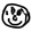
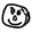
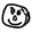
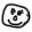
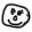
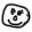
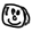
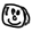
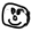
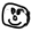
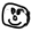
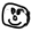
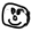
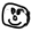
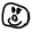
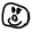
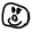
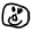
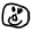


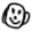
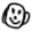
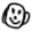
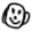
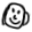
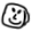
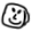
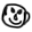
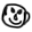
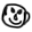
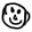
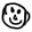
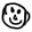
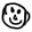
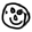
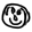
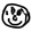
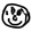
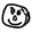
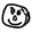
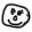
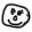
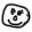
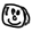
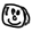
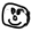
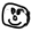
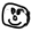
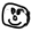
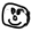
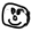
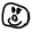
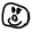
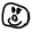
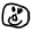
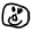

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 4.7822


In [29]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: -inf, params: tensor([ 4.2054e+19,  7.1910e+19, -8.8024e+19,  4.9091e+19, -2.8528e+19,
        -1.3819e+19,  4.0830e+19, -2.8167e+19,  4.8983e+19, -5.4495e+18,
        -7.3827e+19,  3.4408e+19, -5.3118e+18,  5.7811e+19, -1.7828e+19,
        -1.6849e+19,  3.6041e+19, -3.4008e+19, -7.4520e+18, -8.1457e+19,
         5.2755e+19, -1.4233e+18, -1.6136e+19, -1.0107e+20, -1.9295e+18,
        -6.7064e+18,  2.9068e+19, -6.5525e+19,  4.3164e+19,  1.7098e+19,
         5.6135e+19,  2.8673e+19,  7.0308e+19,  1.6556e+19, -3.4542e+19,
         8.4270e+18,  5.3666e+19,  5.9350e+19,  6.5229e+18, -1.0915e+19,
        -6.8300e+18, -2.8125e+19, -2.0104e+19, -1.5540e+18, -8.6174e+19,
        -8.3579e+19, -3.4918e+19, -4.2014e+19,  2.5905e+19,  4.8870e+19,
         3.3966e+19,  3.5217e+19,  2.9468e+19,  1.4733e+19,  2.4053e+19,
        -2.1290e+19,  3.9626e+19, -4.6783e+19, -


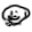
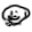
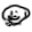
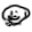
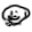
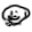
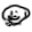
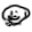
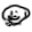
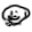
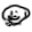
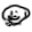
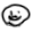
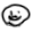
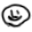
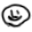
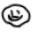
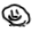
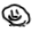
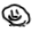
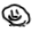
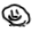
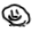
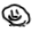
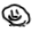
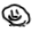
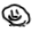
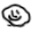
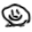
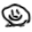
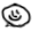
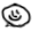
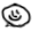
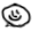
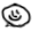
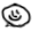


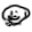
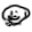
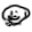
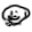
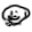
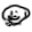
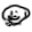
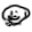
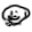
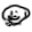
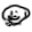
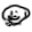
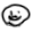
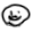
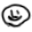
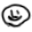
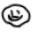
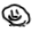
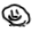
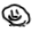
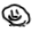
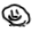
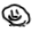
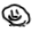
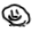
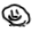
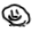
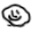
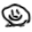
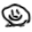
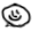
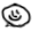
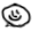
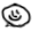
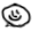
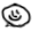

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 4.6136


In [30]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 50

In [31]:
num_steps_ps = 50

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: -inf, params: tensor([-5.3916e+31, -8.2845e+30, -1.1480e+31, -3.9436e+30, -2.4553e+31,
        -1.2299e+31,  1.1844e+32,  4.3037e+30, -1.0586e+32


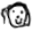
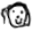
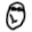
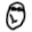
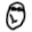
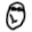
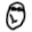
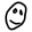
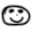
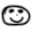
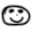
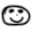
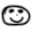
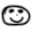
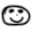
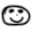
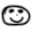
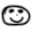
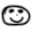
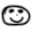
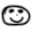
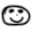
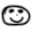
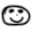
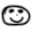
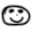
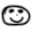
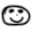
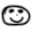
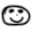
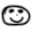
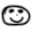
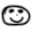
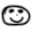
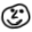
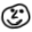


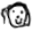
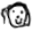
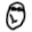
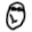
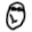
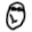
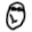
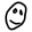
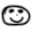
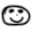
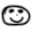
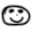
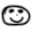
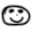
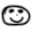
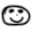
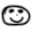
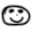
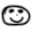
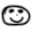
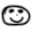
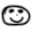
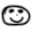
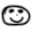
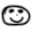
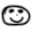
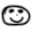
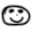
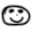
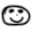
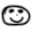
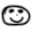
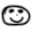
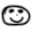
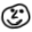
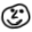

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 19.7749


In [32]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: -inf, params: tensor([ 5.2538e+31,  8.1822e+31, -1.1762e+32,  2.2761e+32, -1.4629e+32,
         5.4596e+30,  7.0875e+31, -2.2347e+31, -1.2163e+32, -1.6259e+32,
        -2.4480e+31,  2.5967e+31,  5.8514e+30,  9.2454e+31, -4.6791e+31,
        -1.4580e+31, -6.9324e+31,  3.3663e+31, -2.4844e+31,  1.5922e+31,
        -1.2823e+31, -4.5485e+31, -6.0257e+31,  3.1481e+31, -5.2873e+31,
        -4.5685e+31, -2.9276e+31,  1.2150e+32, -3.3892e+31,  7.2780e+31,
        -5.1942e+31,  4.3722e+31,  7.0093e+31, -7.7425e+31,  4.6746e+31,
         3.6492e+30, -1.1852e+32, -3.3432e+31,  1.1607e+32, -7.4005e+31,
        -4.5178e+30,  3.4172e+31, -8.7328e+31,  3.5905e+30,  1.0696e+31,
        -1.0604e+32,  1.2099e+30, -6.8008e+31, -8.0077e+31,  3.8951e+31,
         1.0558e+32,  5.2964e+31,  5.5974e+31,  6.3050e+31, -6.1270e+31,
         1.0935e+32, -1.1263e+31,  2.9760e+31, -


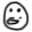
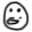
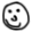
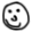
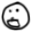
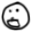
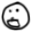
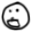
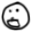
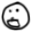
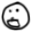
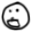
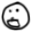
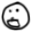
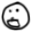
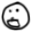
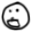
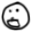
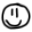
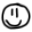
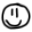
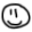
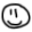
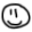
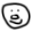
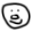
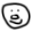
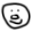
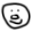
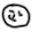
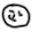
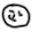
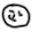
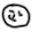
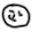
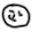


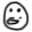
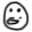
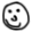
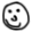
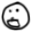
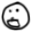
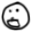
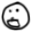
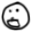
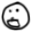
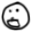
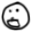
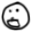
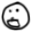
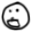
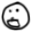
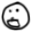
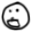
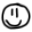
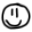
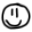
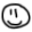
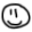
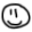
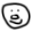
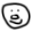
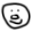
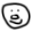
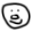
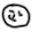
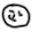
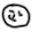
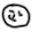
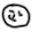
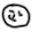
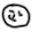

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 18.7328


In [33]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.01409215573221445--- | 50/86 | 4.45       
0d:00:00:19 | 0d:00:00:00 | #################### | 86/86 | 4.54       
Acceptance Rate 0.22



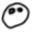
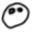
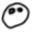
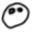
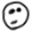
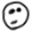
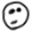
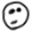
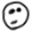
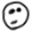
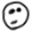
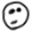
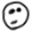
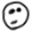
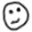
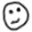
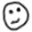
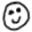
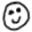
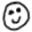
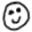
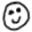
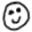
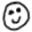
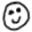
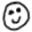
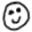
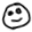
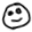
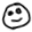
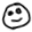
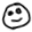
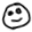
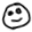
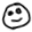
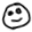


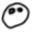
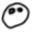
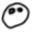
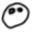
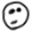
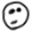
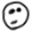
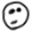
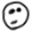
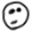
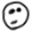
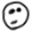
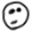
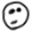
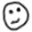
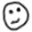
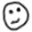
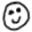
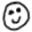
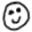
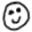
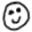
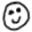
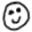
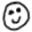
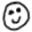
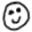
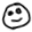
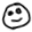
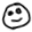
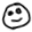
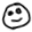
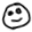
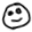
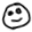
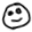

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 19.3533


In [34]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: -inf, params: tensor([-6.2117e+31, -3.9506e+31, -7.8498e+31,  6.5532e+31, -1.3818e+32,
        -5.797


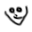
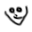
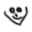
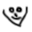
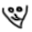
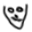
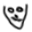
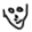
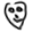
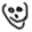
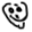
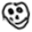
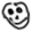
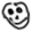
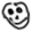
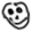
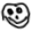
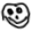
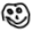
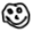
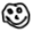
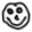
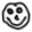
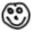
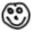
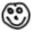
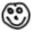
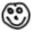
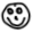
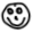
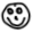
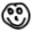
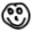
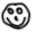
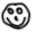
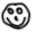


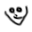
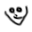
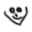
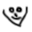
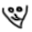
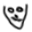
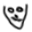
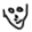
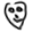
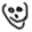
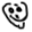
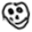
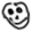
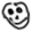
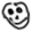
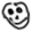
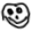
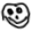
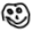
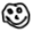
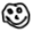
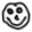
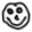
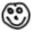
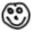
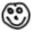
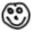
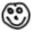
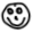
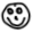
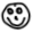
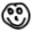
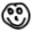
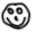
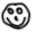
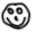

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 23.0007


In [35]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 100

In [36]:
num_steps_ps = 100

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


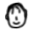
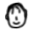
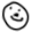
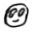
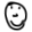
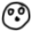
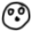
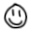
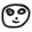
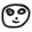
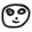
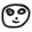
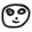
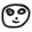
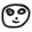
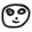
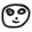
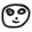
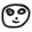
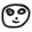
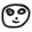
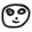
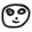
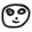
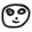
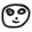
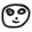
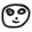
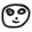
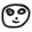
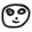
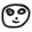
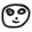
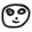
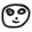
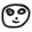


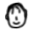
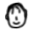
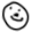
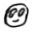
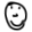
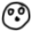
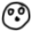
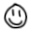
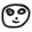
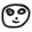
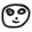
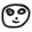
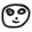
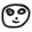
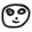
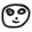
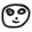
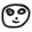
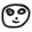
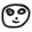
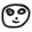
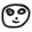
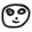
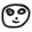
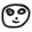
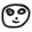
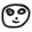
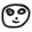
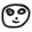
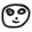
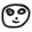
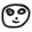
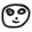
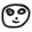
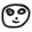
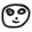

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 37.6000


In [37]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.002746457699686289-- | 50/86 | 2.10       
0d:00:00:41 | 0d:00:00:00 | #################### | 86/86 | 2.11       
Acceptance Rate 0.30



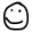
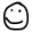
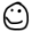
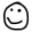
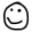
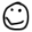
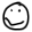
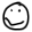
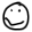
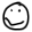
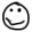
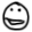
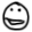
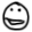
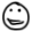
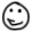
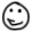
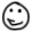
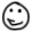
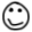
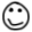
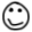
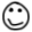
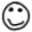
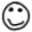
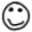
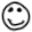
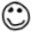
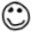
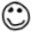
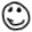
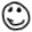
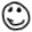
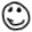
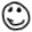
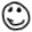


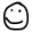
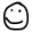
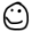
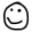
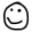
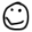
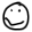
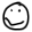
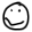
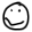
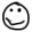
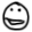
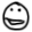
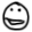
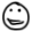
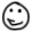
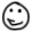
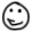
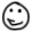
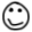
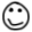
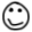
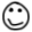
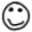
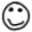
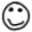
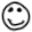
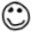
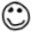
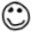
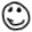
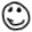
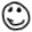
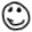
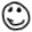
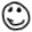

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 41.3337


In [38]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Final Adapted Step Size:  0.004768165294080973-- | 50/86 | 2.19       
0d:00:00:39 | 0d:00:00:00 | ####################


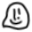
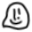
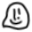
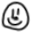
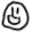
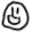
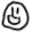
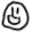
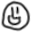
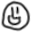
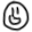
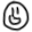
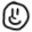
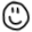
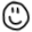
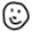
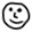
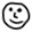
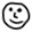
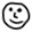
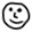
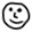
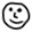
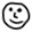
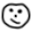
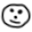
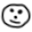
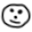
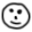
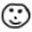
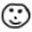
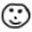
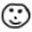
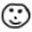
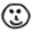
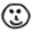


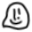
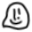
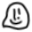
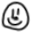
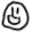
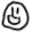
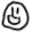
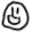
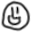
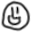
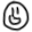
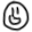
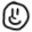
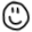
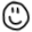
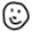
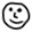
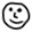
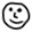
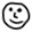
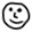
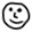
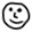
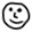
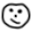
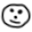
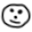
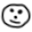
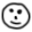
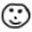
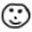
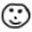
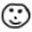
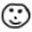
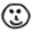
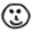

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 39.7527


In [39]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.002684555947780609-- | 50/86 | 2.42       
0d:00:00:37 | 0d:00:00:00 | #################### | 86/86 | 2.30       
Acceptance Rate 0.26



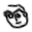
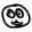
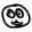
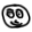
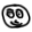
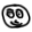
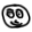
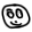
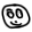
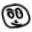
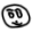
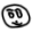
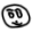
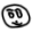
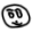
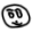
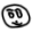
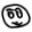
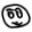
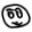
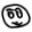
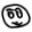
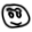
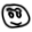
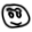
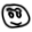
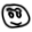
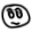
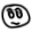
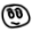
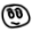
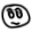
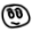
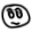
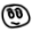
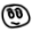


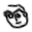
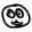
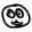
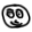
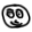
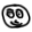
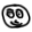
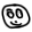
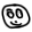
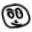
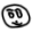
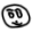
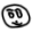
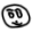
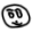
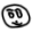
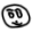
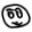
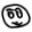
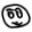
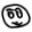
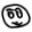
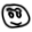
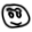
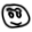
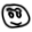
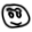
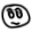
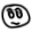
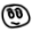
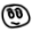
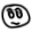
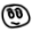
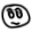
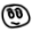
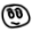

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 38.0595


In [40]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 500

In [41]:
num_steps_ps = 500

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.001687122625298798-- | 50/86 | 0.47       
0d:00:03:02 | 0d:00:00:00 | #################### | 86/86 | 0.48       
Acceptance Rate 0.22



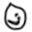
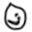
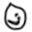
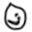
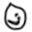
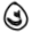
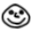
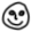
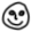
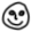
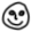
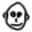
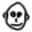
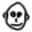
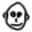
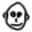
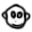
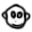
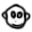
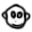
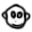
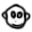
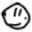
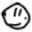
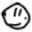
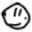
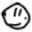
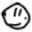
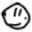
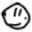
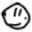
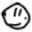
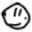
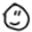
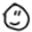
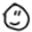


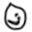
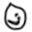
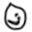
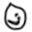
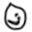
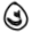
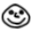
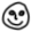
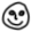
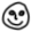
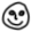
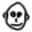
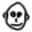
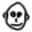
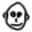
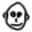
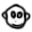
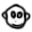
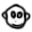
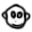
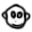
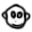
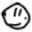
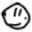
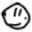
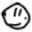
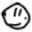
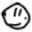
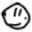
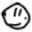
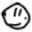
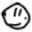
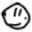
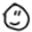
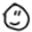
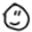

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 182.4809


In [42]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


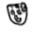
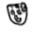
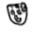
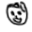
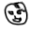
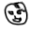
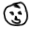
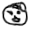
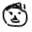
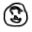
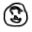
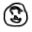
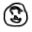
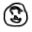
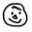
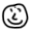
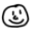
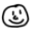
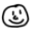
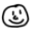
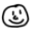
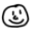
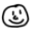
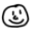
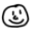
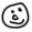
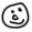
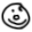
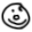
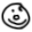
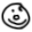
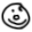
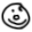
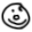
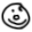
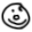


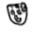
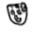
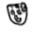
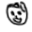
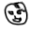
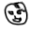
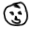
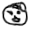
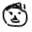
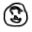
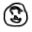
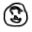
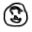
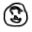
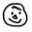
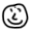
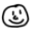
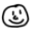
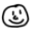
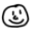
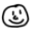
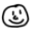
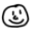
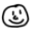
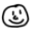
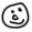
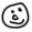
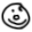
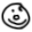
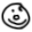
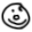
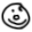
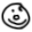
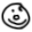
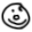
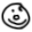

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 163.6162


In [43]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


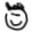
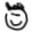
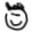
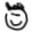
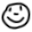
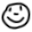
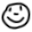
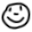
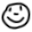
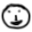
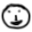
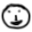
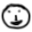
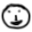
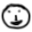
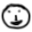
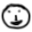
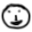
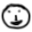
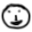
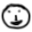
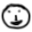
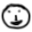
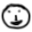
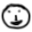
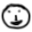
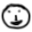
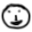
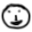
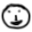
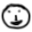
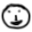
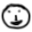
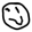
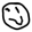
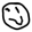


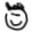
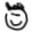
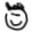
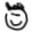
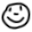
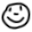
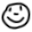
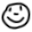
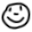
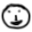
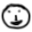
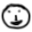
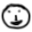
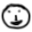
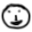
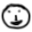
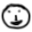
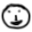
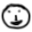
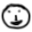
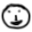
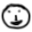
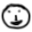
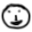
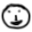
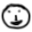
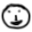
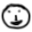
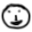
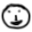
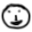
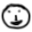
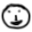
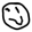
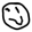
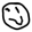

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 169.6197


In [44]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.0003974107385147363- | 50/86 | 0.55       
0d:00:02:41 | 0d:00:00:00 | #################### | 86/86 | 0.54       
Acceptance Rate 0.28



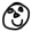
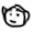
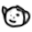
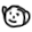
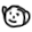
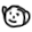
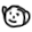
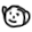
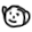
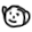
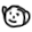
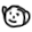
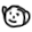
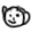
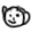
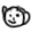
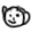
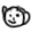
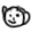
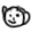
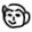
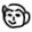
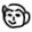
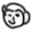
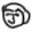
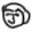
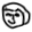
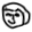
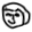
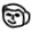
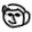
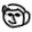
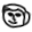
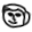
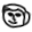
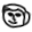


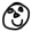
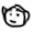
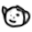
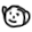
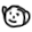
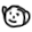
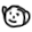
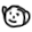
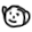
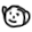
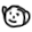
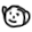
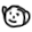
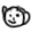
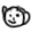
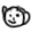
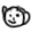
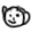
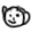
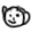
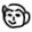
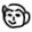
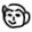
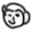
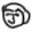
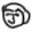
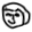
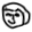
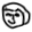
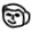
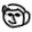
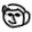
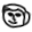
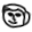
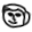
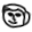

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 161.9211


In [45]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps)

---

## Num steps per sample = 1.000

In [46]:
num_steps_ps = 1_000
burn = 20

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec


Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,


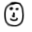
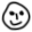
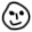
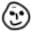
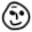
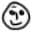
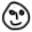
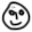
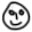
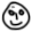
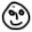
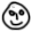
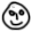
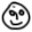
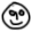
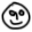
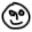
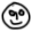
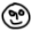
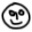
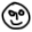
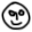
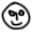
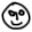
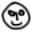
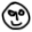
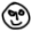
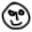
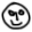
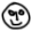
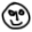
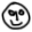
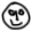
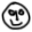
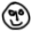
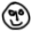


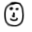
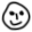
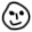
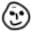
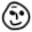
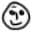
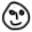
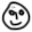
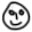
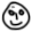
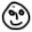
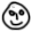
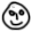
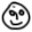
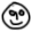
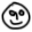
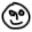
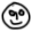
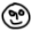
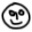
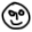
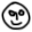
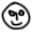
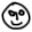
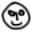
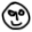
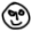
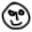
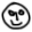
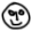
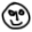
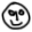
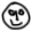
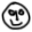
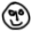
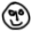

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 218.1809


In [47]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 10

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


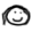
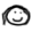
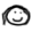
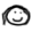
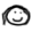
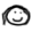
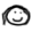
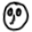
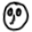
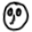
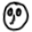
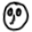
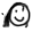
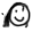
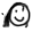
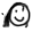
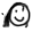
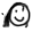
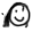
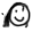
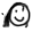
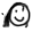
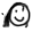
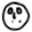
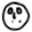
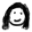
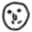
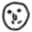
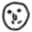
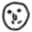
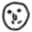
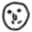
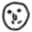
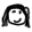
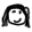
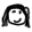


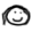
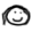
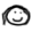
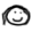
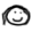
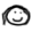
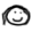
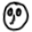
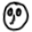
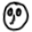
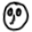
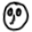
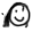
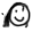
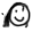
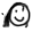
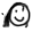
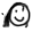
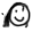
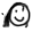
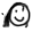
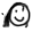
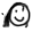
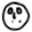
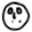
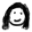
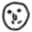
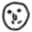
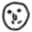
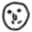
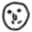
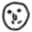
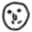
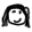
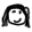
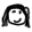

post_pi_n = NUTSPosteriorPiN(n_data=10, n_total_samples=36)
post_pi_n.total_time = 262.2415


In [48]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 25

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Final Adapted Step Size:  0.009092516265809536-- | 20/56 | 0.24       
0d:00:03:56 | 0d:00:00:00 | ####################


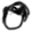
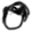
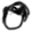
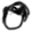
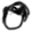
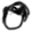
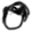
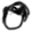
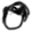
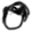
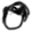
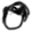
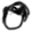
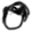
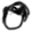
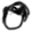
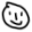
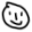
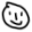
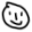
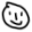
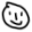
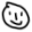
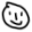
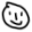
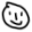
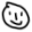
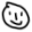
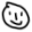
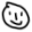
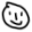
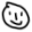
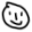
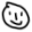
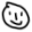
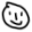


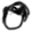
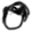
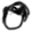
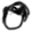
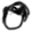
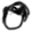
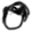
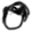
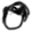
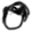
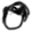
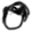
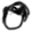
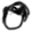
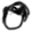
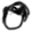
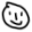
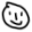
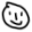
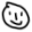
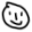
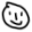
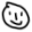
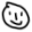
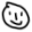
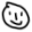
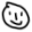
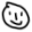
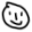
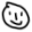
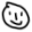
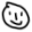
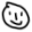
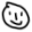
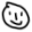
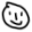

post_pi_n = NUTSPosteriorPiN(n_data=25, n_total_samples=36)
post_pi_n.total_time = 236.9958


In [49]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 50

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


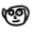
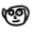
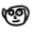
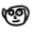
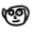
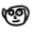
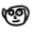
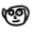
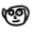
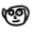
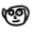
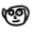
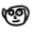
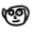
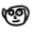
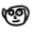
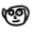
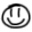
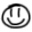
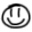
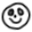
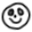
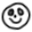
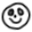
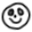
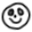
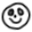
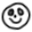
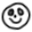
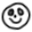
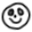
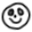
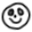
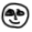
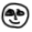
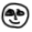


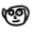
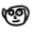
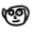
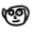
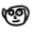
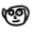
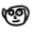
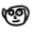
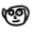
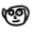
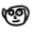
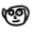
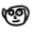
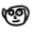
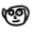
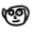
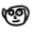
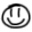
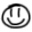
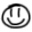
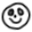
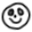
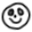
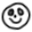
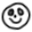
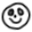
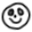
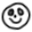
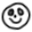
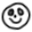
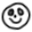
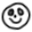
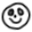
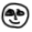
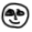
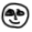

post_pi_n = NUTSPosteriorPiN(n_data=50, n_total_samples=36)
post_pi_n.total_time = 260.2302


In [50]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

---

## Num steps per sample = 10.000

In [51]:
num_steps_ps = 10_000
burn = 10

### N Data = 5

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 


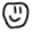
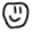
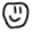
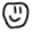
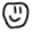
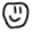
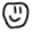
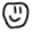
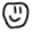
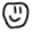
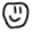
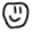
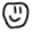
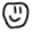
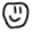
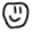
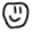
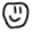
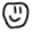
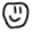
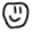
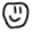
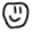
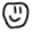
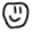
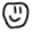
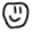
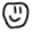
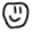
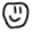
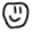
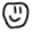
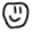
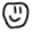
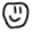
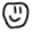


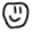
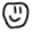
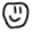
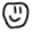
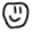
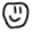
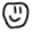
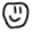
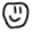
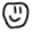
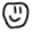
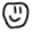
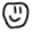
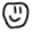
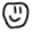
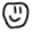
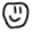
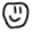
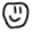
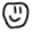
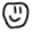
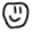
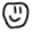
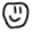
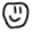
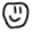
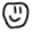
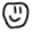
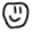
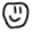
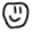
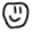
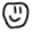
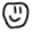
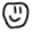
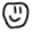

post_pi_n = NUTSPosteriorPiN(n_data=5, n_total_samples=36)
post_pi_n.total_time = 2781.9968


In [52]:
n_data = 5
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 10

In [53]:
n_data = 10
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       requires_grad=True)
Invalid log_prob: nan, params: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

Traceback (most recent call last):
  File "/tmp/ipykernel_207882/2574090871.py", line 9, in mcmc_experiment
    post_pi_n.reset_samples().run(num_samples=max_images)
  File "/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/bwb/distributions/posterior_distributions.py", line 39, in timeit_wrapper
    result = method(*args, **kwargs)
  File "/tmp/ipykernel_207882/3893860954.py", line 90, in run
    samples = hamiltorch.sample(**hamiltorch_kwargs)
  File "/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/.venv/lib/python3.10/site-packages/hamiltorch/samplers.py", line 973, in sample
    leapfrog_params, leapfrog_momenta = leapfrog(params, momentum, log_prob_func, sampler=sampler, integrator=integrator, steps=num_steps_per_sample, step_size=step_size, inv_mass=inv_mass, jitter=jitter, jitter_max_tries=jitter_max_tries, fixed_point_threshold=fixed_point_threshold, fixed_point_max_iterations=fixed_point_max_iteratio

### N Data = 25

In [ ]:
n_data = 25
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)

### N Data = 50

In [ ]:
n_data = 50
mcmc_experiment(data[:n_data], num_steps_per_sample=num_steps_ps, burn=burn)